# Making an accurate detector for fake disaster data

Let's try to fit prediction models from text data

### Import libraries

In [1]:
import string
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk

### Data loading

In [32]:
# Load csv data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Remove duplicated text from train set
train[train['text'].duplicated(keep='first')]

# Prepare train and test set
X_train, y_train = train['text'], train['target']
X_test = test['text']

## Text preprocessing

Text preprocessing from the analysis done in the previous notebooks

1. Convert to lower

In [33]:
X_train = X_train.str.lower()
X_test = X_test.str.lower()

2. Replace web url and number terms with tokens

In [34]:
# Replace URL by token TweburlT
url_replacer = re.compile(r'\bhttps?:\/\/[^ ]+\b')
X_train = X_train.apply(lambda x: url_replacer.sub(' TweburlT ', x))
X_test = X_test.apply(lambda x: url_replacer.sub(' TweburlT ', x))

In [35]:
# Replace year by TyearT
year_replacer = re.compile(r'\b(?:19\d{2}|2\d{3})\b')
X_train = X_train.apply(lambda x: year_replacer.sub(' TyearT ', x))
X_test = X_test.apply(lambda x: year_replacer.sub(' TyearT ', x))

In [36]:
# Replace hours by ThourT
hour_replacer = re.compile(r'\b\d{2}:\d{2}(?::\d{2}(?:[,.:]\d+)?)?\b')
X_train = X_train.apply(lambda x: hour_replacer.sub(' ThourT ', x))
X_test = X_test.apply(lambda x: hour_replacer.sub(' ThourT ', x))

In [37]:
# Replace numbers by TnumberT
num_replacer = re.compile(r'\d+([.,]\d+)?')
X_train = X_train.apply(lambda x: num_replacer.sub(' TnumberT ', x))
X_test = X_test.apply(lambda x: num_replacer.sub(' TnumberT ', x))

In [38]:
# Replace emojis by TemojiT
emoji_replacer = re.compile("["
    "\U0001F1E0-\U0001F1FF"  # flags (iOS)
    "\U0001F300-\U0001F5FF"  # symbols & pictographs
    "\U0001F600-\U0001F64F"  # emoticons
    "\U0001F680-\U0001F6FF"  # transport & map symbols
    "\U0001F700-\U0001F77F"  # alchemical symbols
    "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
    "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
    "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
    "\U0001FA00-\U0001FA6F"  # Chess Symbols
    "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
    "\U00002702-\U000027B0"  # Dingbats
    "]+")
X_train = X_train.apply(lambda x: emoji_replacer.sub(' TemojiT ', x))
X_test = X_test.apply(lambda x: emoji_replacer.sub(' TemojiT ', x))

3. Remove punctuation symbols

In [39]:
remove_punctuation = lambda text: text.translate(text.maketrans('', '', string.punctuation))
X_train = X_train.apply(remove_punctuation)
X_test = X_test.apply(remove_punctuation)

4. Tokenize

In [40]:
X_train = X_train.apply(nltk.word_tokenize)
X_test = X_test.apply(nltk.word_tokenize)

5. Remove stopwords

In [41]:
eng_stopwords = nltk.corpus.stopwords.words('english')

def remove_stopwords(record):
    return [word for word in record if word not in eng_stopwords]

In [42]:
X_train = X_train.apply(remove_stopwords)
X_test = X_test.apply(remove_stopwords)

6. Stem the words

In [43]:
porter = nltk.PorterStemmer()
stem_text = lambda record: [porter.stem(word) for word in record]

In [44]:
X_train = X_train.apply(stem_text)
X_test = X_test.apply(stem_text)

7. Remove the less frequent words

In [45]:
def word_frequency(pd_series):
    word_freq = {}
    
    for rec in pd_series:
        for word in rec:
            if word not in word_freq:
                word_freq[word] = 1
            else:
                word_freq[word] += 1
    
    return word_freq

In [46]:
# Retrieve the list of words with a fewer frequency than 10 repetitions
train_word_freq = pd.Series(word_frequency(X_train))
less_freq_words = set(train_word_freq[train_word_freq <= 10].index)

In [47]:
# Remove less frequent words
remove_less_frequent = lambda x: [word for word in x if word not in less_freq_words]
X_train_red = X_train.apply(remove_less_frequent)
X_test_red = X_test.apply(remove_less_frequent)

Trun array of words back into string separated by spaces

In [48]:
X_train_red = X_train_red.apply(lambda x: ' '.join(x))
X_test_red = X_test_red.apply(lambda x: ' '.join(x))

## Text vectorization

Vectorize text by using term frequency - inverse document frequency codification

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

In [50]:
# Vectorize train set
X_train_vect = vectorizer.fit_transform(X_train_red)

In [51]:
# Vectorize test set
X_test_vect = vectorizer.transform(X_test_red)

In [65]:
print('Number of columns: ', X_train_vect.shape[1])

Number of columns:  1278


## Model fitting

### Support Vector Machine

Let's try with SVM. Validation through Stratified K-Fold with `K=5` will be applied

In [22]:
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.model_selection import ParameterGrid
from sklearn import metrics

In [23]:
K = 5
kfold = StratifiedKFold(n_splits=K)

Fit model by trying different `kernels` and values for parameters `C`, `degree` (for polynomical kernel).
1. Kernel rbf

In [29]:
kernel = 'rbf'
C_values = np.arange(0.5, 10, 0.5)

In [30]:
svm_rbf_perf = [] # To Save model performance statics

for C in C_values:
    np.random.seed(1)
    param = {
        'kernel': 'rbf',
        'C': C,
        'accuracy_fold': [],
        'precision_fold': [],
        'recall_fold': [],
        'specificity_fold': [],
        'f1_score_fold': []
    }

    for train_index, test_index in kfold.split(X_train_vect, y_train):
    
        # Split train and test partition
        X_train_part = X_train_vect[train_index]
        y_train_part = y_train[train_index].values
        
        X_test_part = X_train_vect[test_index]
        y_test_part = y_train[test_index].values
        
        # Fit SVM model
        svm = SVC(kernel=kernel, C=C)
        svm.fit(X_train_part, y_train_part)
        
        # Predict over test
        y_pred = svm.predict(X_test_part)
        
        # Meassure performance metrics
        param['accuracy_fold'].append(metrics.accuracy_score(y_test_part, y_pred))
        param['precision_fold'].append(metrics.precision_score(y_test_part, y_pred))
        param['recall_fold'].append(metrics.recall_score(y_test_part, y_pred))
        #  Exchange class 1 and 0 so measure recall for class 0 (specificity)
        param['specificity_fold'].append(metrics.recall_score(np.abs(y_test_part-1), np.abs(y_pred-1)))
        param['f1_score_fold'].append(metrics.f1_score(y_test_part, y_pred))
    
    # Compute global average metrics
    param['accuracy_avg'] = np.mean(param['accuracy_fold'])
    param['accuracy_std'] = np.std(param['accuracy_fold'])
    
    param['precision_avg'] = np.mean(param['precision_fold'])
    param['precision_std'] = np.std(param['precision_fold'])
    
    param['recall_avg'] = np.mean(param['recall_fold'])
    param['recall_std'] = np.std(param['recall_fold'])
    
    param['specificity_avg'] = np.mean(param['specificity_fold'])
    param['specificity_std'] = np.std(param['specificity_fold'])
    
    param['f1_score_avg'] = np.mean(param['f1_score_fold'])
    param['f1_score_std'] = np.std(param['f1_score_fold'])
    
    svm_rbf_perf.append(param)

svm_rbf_perf = pd.DataFrame(svm_rbf_perf)

Plot graphic performance evolution respecting parameter C

In [24]:
def plot_performance(perf_df, param, param_name=None):
    
    if not param_name:
        param_name = param

    fig, ax = plt.subplots(3,2, figsize=(16,20))

    # Plot accuracy
    ax[0, 0].fill_between(perf_df[param].values,
                     perf_df['accuracy_fold'].apply(np.min),
                     perf_df['accuracy_fold'].apply(np.max), color='lightblue')
    ax[0, 0].plot(perf_df[param].values, perf_df['accuracy_avg'].values, color='tab:blue')
    ax[0, 0].set_xlabel(param_name)
    ax[0, 0].set_ylabel('Accuracy')
    ax[0, 0].set_title('Accuracy evolution against {}'.format(param_name))
    
    # Plot precision
    ax[0, 1].fill_between(perf_df[param].values,
                     perf_df['precision_fold'].apply(np.min),
                     perf_df['precision_fold'].apply(np.max), color='coral')
    ax[0, 1].plot(perf_df[param].values, perf_df['precision_avg'].values, color='tab:red')
    ax[0, 1].set_xlabel(param_name)
    ax[0, 1].set_ylabel('Precision')
    ax[0, 1].set_title('Precision evolution against {}'.format(param_name))
    
    # Plot recall
    ax[1, 0].fill_between(perf_df[param].values,
                     perf_df['recall_fold'].apply(np.min),
                     perf_df['recall_fold'].apply(np.max), color='lightgreen')
    ax[1, 0].plot(perf_df[param].values, perf_df['recall_avg'].values, color='tab:green')
    ax[1, 0].set_xlabel(param_name)
    ax[1, 0].set_ylabel('Recall')
    ax[1, 0].set_title('Recall evolution against {}'.format(param_name))
    
    # Plot specificity
    ax[1, 1].fill_between(perf_df[param].values,
                     perf_df['specificity_fold'].apply(np.min),
                     perf_df['specificity_fold'].apply(np.max), color='orange')
    ax[1, 1].plot(perf_df[param].values, perf_df['specificity_avg'].values, color='tab:orange')
    ax[1, 1].set_xlabel(param_name)
    ax[1, 1].set_ylabel('Specificity')
    ax[1, 1].set_title('Specificity evolution against {}'.format(param_name))

    # Plot f1 score
    ax[2, 0].fill_between(perf_df[param].values,
                     perf_df['f1_score_fold'].apply(np.min),
                     perf_df['f1_score_fold'].apply(np.max), color='lightpink')
    ax[2, 0].plot(perf_df[param].values, perf_df['f1_score_avg'].values, color='tab:pink')
    ax[2, 0].set_xlabel(param_name)
    ax[2, 0].set_ylabel('F1 Score')
    ax[2, 0].set_title('F1 Score evolution against {}'.format(param_name))
    
    plt.show()
    return fig, ax

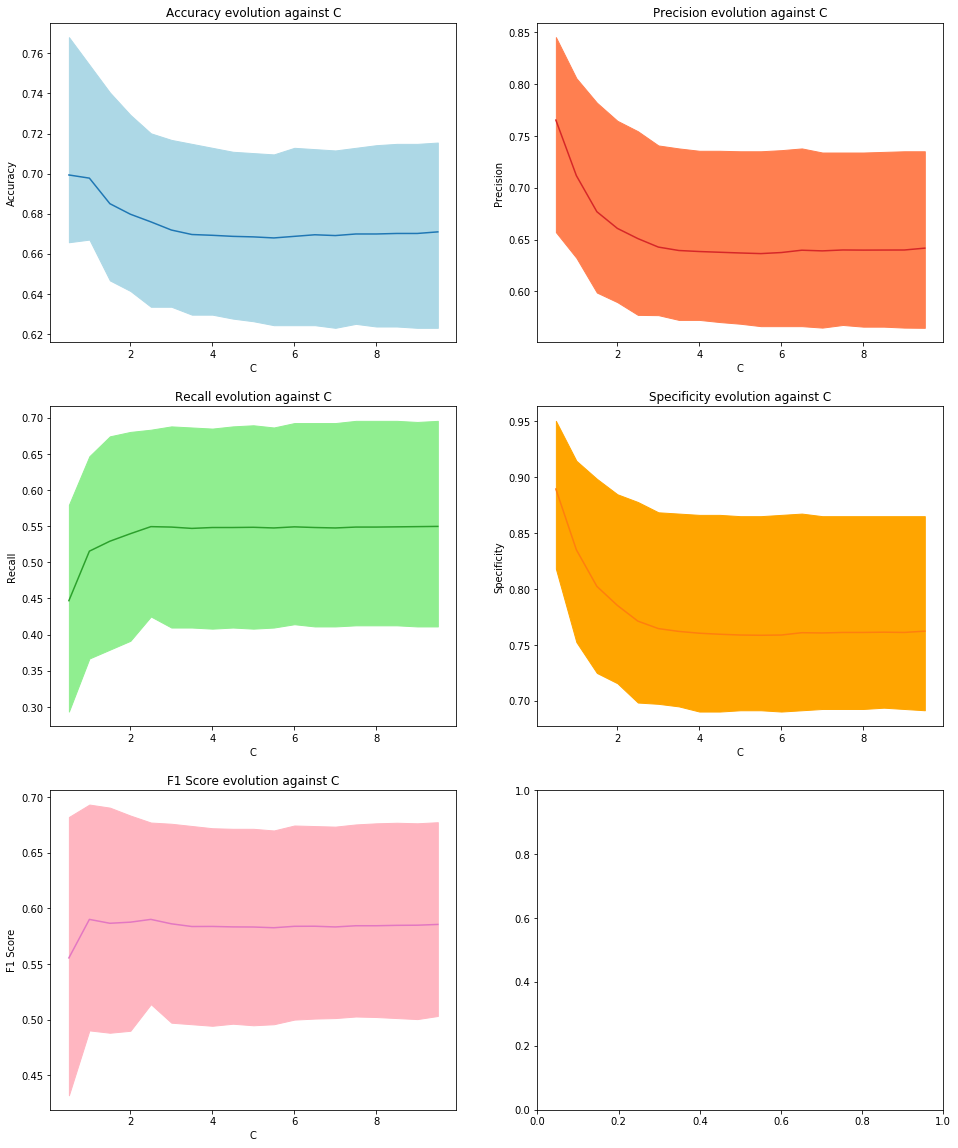

(<Figure size 1152x1440 with 6 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f816e6b1ac8>,
       dtype=object))

In [31]:
plot_performance(svm_rbf_perf, param='C')

In [32]:
# Show performance table
svm_rbf_perf

kernel    C                                      accuracy_fold  \
0     rbf  0.5  [0.7137229152987524, 0.6657912015758372, 0.680...   
1     rbf  1.0  [0.7229152987524623, 0.6671043992120814, 0.672...   
2     rbf  1.5  [0.7196323046618516, 0.6467498358502954, 0.659...   
3     rbf  2.0  [0.7176625082074852, 0.6414970453053185, 0.660...   
4     rbf  2.5  [0.7143795141168746, 0.6336178594878529, 0.657...   
5     rbf  3.0  [0.7091267235718975, 0.6336178594878529, 0.655...   
6     rbf  3.5  [0.7071569271175312, 0.6296782665791202, 0.654...   
7     rbf  4.0  [0.7058437294812869, 0.6296782665791202, 0.656...   
8     rbf  4.5  [0.7058437294812869, 0.6277084701247537, 0.656...   
9     rbf  5.0  [0.706500328299409, 0.6263952724885096, 0.6572...   
10    rbf  5.5  [0.706500328299409, 0.6244254760341431, 0.6572...   
11    rbf  6.0  [0.706500328299409, 0.6244254760341431, 0.6559...   
12    rbf  6.5  [0.7071569271175312, 0.6244254760341431, 0.655...   
13    rbf  7.0  [0.7051871306631649, 0.6231122783978988, 0.657...   
14    rbf  7.5  [0.7051871306631649, 0.6250820748522653, 0.657...   
15    rbf  8.0  [0.7051871306631649, 0.623768877216021, 0.6579...   
16    rbf  8.5  [0.7058437294812869, 0.623768877216021, 0.6592...   
17    rbf  9.0  [0.706500328299409, 0.6231122783978988, 0.6592...   
18    rbf  9.5  [0.706500328299409, 0.6231122783978988, 0.6585...   

                                       precision_fold  \
0   [0.8454258675078864, 0.6572668112798264, 0.677...   
1   [0.8057742782152231, 0.634862385321101, 0.6324...   
2   [0.7821782178217822, 0.5989761092150171, 0.610...   
3   [0.7647058823529411, 0.5897009966777409, 0.608...   
4   [0.7546296296296297, 0.5774193548387097, 0.602...   
5   [0.740909090909091, 0.5771704180064309, 0.5993...   
6   [0.7380410022779044, 0.5725806451612904, 0.597...   
7   [0.7357630979498861, 0.5725806451612904, 0.597...   
8   [0.7357630979498861, 0.5705024311183144, 0.597...   
9   [0.7352941176470589, 0.5688816855753647, 0.598...   
10  [0.7352941176470589, 0.5665584415584416, 0.598...   
11  [0.7363636363636363, 0.5665584415584416, 0.597...   
12  [0.7380410022779044, 0.5665584415584416, 0.597...   
13  [0.7340909090909091, 0.5651465798045603, 0.599...   
14  [0.7340909090909091, 0.567699836867863, 0.5990...   
15  [0.7340909090909091, 0.566068515497553, 0.5997...   
16  [0.7346938775510204, 0.566068515497553, 0.6015...   
17  [0.7352941176470589, 0.5651465798045603, 0.600...   
18  [0.7352941176470589, 0.564935064935065, 0.6002...   

                                          recall_fold  \
0   [0.40916030534351144, 0.463302752293578, 0.489...   
1   [0.4687022900763359, 0.5290519877675841, 0.565...   
2   [0.48244274809160304, 0.536697247706422, 0.573...   
3   [0.4961832061068702, 0.5428134556574924, 0.587...   
4   [0.49770992366412214, 0.5474006116207951, 0.59...   
5   [0.49770992366412214, 0.5489296636085627, 0.59...   
6   [0.4946564885496183, 0.5428134556574924, 0.600...   
7   [0.49312977099236643, 0.5428134556574924, 0.61...   
8   [0.49312977099236643, 0.5382262996941896, 0.61...   
9   [0.4961832061068702, 0.536697247706422, 0.6116...   
10  [0.4961832061068702, 0.5336391437308868, 0.611...   
11  [0.4946564885496183, 0.5336391437308868, 0.610...   
12  [0.4946564885496183, 0.5336391437308868, 0.608...   
13  [0.49312977099236643, 0.5305810397553516, 0.61...   
14  [0.49312977099236643, 0.5321100917431193, 0.61...   
15  [0.49312977099236643, 0.5305810397553516, 0.61...   
16  [0.4946564885496183, 0.5305810397553516, 0.611...   
17  [0.4961832061068702, 0.5305810397553516, 0.614...   
18  [0.4961832061068702, 0.5321100917431193, 0.613...   

                                     specificity_fold  \
0   [0.9435483870967742, 0.8181818181818182, 0.825...   
1   [0.9147465437788018, 0.7710011507479861, 0.752...   
2   [0.8986175115207373, 0.7295742232451093, 0.724...   
3   [0.8847926267281107, 0.715765247410817, 0.7157...   
4   [0.8778801843317973, 0.6985040276179517, 0.705...  

Show model with best accuracy and best f1-score

In [33]:
svm_rbf_perf.nlargest(1, 'accuracy_avg')[['C', 'kernel',
                                          'accuracy_avg',
                                          'precision_avg',
                                          'recall_avg',
                                          'specificity_avg',
                                          'f1_score_avg']]

C kernel  accuracy_avg  precision_avg  recall_avg  specificity_avg  \
0  0.5    rbf      0.699335         0.7654     0.44697         0.889483   

   f1_score_avg  
0      0.555507

In [34]:
svm_rbf_perf.nlargest(1, 'f1_score_avg')[['C', 'kernel',
                                          'accuracy_avg',
                                          'precision_avg',
                                          'recall_avg',
                                          'specificity_avg',
                                          'f1_score_avg']]

C kernel  accuracy_avg  precision_avg  recall_avg  specificity_avg  \
1  1.0    rbf      0.697758       0.711785    0.515453         0.835133   

   f1_score_avg  
1      0.590161

Summary points:
* The lower `C` offers a higher overall accuracy but the lower performance to indentify disaster tweets and the largest for non-disaster tweets.
* On increasing `C`, overall accuracy decreases while disaster tweets increases and f1-scores increases until reaching flat.
* Model with highest accuracy is reachen on `C=0.5` and model with higuest f1-score on `C=1`. Last one would offer a better balance between higuer accuracy and f1-score.

2. Linear kernel

In [35]:
kernel = 'linear'
C_values = np.arange(0.5, 10, 0.5)

In [36]:
svm_lin_perf = [] # To Save model performance statics

for C in C_values:
    np.random.seed(1)
    param = {
        'kernel': kernel,
        'C': C,
        'accuracy_fold': [],
        'precision_fold': [],
        'recall_fold': [],
        'specificity_fold': [],
        'f1_score_fold': []
    }

    for train_index, test_index in kfold.split(X_train_vect, y_train):
    
        # Split train and test partition
        X_train_part = X_train_vect[train_index]
        y_train_part = y_train[train_index].values
        
        X_test_part = X_train_vect[test_index]
        y_test_part = y_train[test_index].values
        
        # Fit SVM model
        svm = SVC(kernel=kernel, C=C)
        svm.fit(X_train_part, y_train_part)
        
        # Predict over test
        y_pred = svm.predict(X_test_part)
        
        # Meassure performance metrics
        param['accuracy_fold'].append(metrics.accuracy_score(y_test_part, y_pred))
        param['precision_fold'].append(metrics.precision_score(y_test_part, y_pred))
        param['recall_fold'].append(metrics.recall_score(y_test_part, y_pred))
        #  Exchange class 1 and 0 so measure recall for class 0 (specificity)
        param['specificity_fold'].append(metrics.recall_score(np.abs(y_test_part-1), np.abs(y_pred-1)))
        param['f1_score_fold'].append(metrics.f1_score(y_test_part, y_pred))
    
    # Compute global average metrics
    param['accuracy_avg'] = np.mean(param['accuracy_fold'])
    param['accuracy_std'] = np.std(param['accuracy_fold'])
    
    param['precision_avg'] = np.mean(param['precision_fold'])
    param['precision_std'] = np.std(param['precision_fold'])
    
    param['recall_avg'] = np.mean(param['recall_fold'])
    param['recall_std'] = np.std(param['recall_fold'])
    
    param['specificity_avg'] = np.mean(param['specificity_fold'])
    param['specificity_std'] = np.std(param['specificity_fold'])
    
    param['f1_score_avg'] = np.mean(param['f1_score_fold'])
    param['f1_score_std'] = np.std(param['f1_score_fold'])
    
    svm_lin_perf.append(param)

svm_lin_perf = pd.DataFrame(svm_lin_perf)

Compare model performance against parameter C

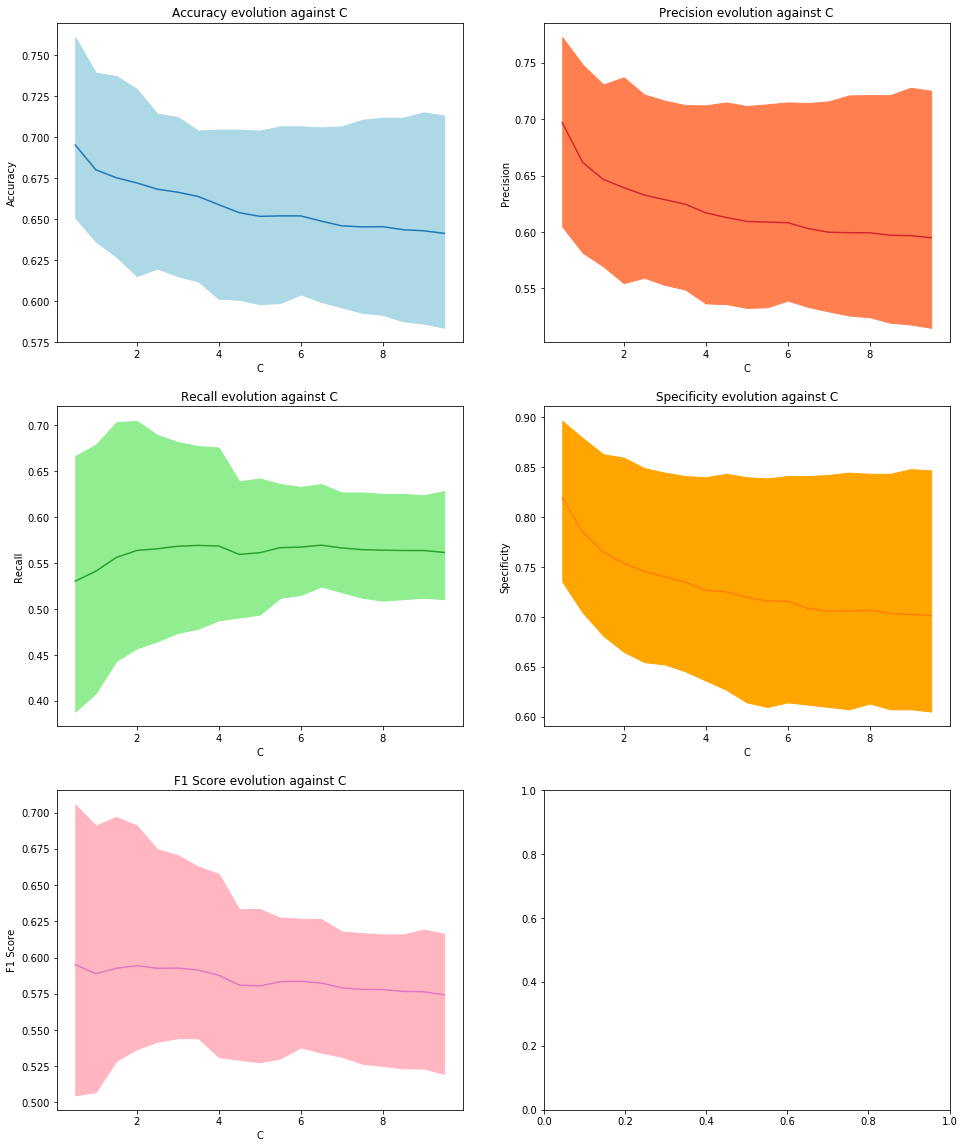

(<Figure size 1152x1440 with 6 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f816e7166a0>,
       dtype=object))

In [38]:
plot_performance(svm_lin_perf, param='C')

In [39]:
svm_lin_perf

kernel    C                                      accuracy_fold  \
0   linear  0.5  [0.7117531188443861, 0.6506894287590282, 0.679...   
1   linear  1.0  [0.7058437294812869, 0.6362442547603414, 0.659...   
2   linear  1.5  [0.7038739330269206, 0.6270518713066316, 0.647...   
3   linear  2.0  [0.7143795141168746, 0.6152330925804333, 0.640...   
4   linear  2.5  [0.7071569271175312, 0.6198292843072882, 0.637...   
5   linear  3.0  [0.7051871306631649, 0.6152330925804333, 0.640...   
6   linear  3.5  [0.7038739330269206, 0.6119500984898227, 0.638...   
7   linear  4.0  [0.7045305318450427, 0.6014445173998687, 0.632...   
8   linear  4.5  [0.7045305318450427, 0.6007879185817465, 0.625...   
9   linear  5.0  [0.7038739330269206, 0.5981615233092581, 0.618...   
10  linear  5.5  [0.706500328299409, 0.5988181221273802, 0.6172...   
11  linear  6.0  [0.706500328299409, 0.6040709126723572, 0.6185...   
12  linear  6.5  [0.7058437294812869, 0.5994747209455022, 0.617...   
13  linear  7.0  [0.706500328299409, 0.5961917268548916, 0.6172...   
14  linear  7.5  [0.7104399212081418, 0.592908732764281, 0.6158...   
15  linear  8.0  [0.7117531188443861, 0.5915955351280368, 0.618...   
16  linear  8.5  [0.7117531188443861, 0.587655942219304, 0.6152...   
17  linear  9.0  [0.7150361129349967, 0.5863427445830598, 0.614...   
18  linear  9.5  [0.7130663164806303, 0.5837163493105713, 0.615...   

                                       precision_fold  \
0   [0.7727272727272727, 0.6048109965635738, 0.636...   
1   [0.7482014388489209, 0.5814332247557004, 0.605...   
2   [0.7307692307692307, 0.56957928802589, 0.58718...   
3   [0.7370689655172413, 0.5546623794212219, 0.577...   
4   [0.721868365180467, 0.5594294770206022, 0.5726...   
5   [0.7163865546218487, 0.553125, 0.5746478873239...   
6   [0.7125, 0.5489891135303266, 0.571627260083449...   
7   [0.7122153209109731, 0.5366614664586583, 0.565...   
8   [0.7148846960167715, 0.5360501567398119, 0.557...   
9   [0.7116182572614108, 0.5327102803738317, 0.549...   
10  [0.7131147540983607, 0.5332302936630603, 0.547...   
11  [0.7148760330578512, 0.5391705069124424, 0.549...   
12  [0.7142857142857143, 0.5335365853658537, 0.548...   
13  [0.7157676348547718, 0.5295902883156297, 0.547...   
14  [0.7210743801652892, 0.5259146341463414, 0.545...   
15  [0.7213114754098361, 0.524390243902439, 0.5489...   
16  [0.7213114754098361, 0.5195783132530121, 0.545...   
17  [0.7278350515463917, 0.5179640718562875, 0.544...   
18  [0.7252066115702479, 0.515015015015015, 0.5450...   

                                          recall_fold  \
0   [0.467175572519084, 0.5382262996941896, 0.5917...   
1   [0.4763358778625954, 0.5458715596330275, 0.596...   
2   [0.49312977099236643, 0.5382262996941896, 0.60...   
3   [0.5221374045801527, 0.5275229357798165, 0.607...   
4   [0.5190839694656488, 0.5397553516819572, 0.614...   
5   [0.5206106870229008, 0.5412844036697247, 0.623...   
6   [0.5221374045801527, 0.5397553516819572, 0.628...   
7   [0.5251908396946565, 0.5259938837920489, 0.628...   
8   [0.5206106870229008, 0.5229357798165137, 0.623...   
9   [0.5236641221374045, 0.5229357798165137, 0.623...   
10  [0.5312977099236641, 0.5275229357798165, 0.626...   
11  [0.5282442748091603, 0.536697247706422, 0.6238...   
12  [0.5267175572519084, 0.5351681957186545, 0.625...   
13  [0.5267175572519084, 0.5336391437308868, 0.626...   
14  [0.5328244274809161, 0.5275229357798165, 0.626...   
15  [0.5374045801526718, 0.5259938837920489, 0.625...   
16  [0.5374045801526718, 0.5275229357798165, 0.625...   
17  [0.5389312977099237, 0.5290519877675841, 0.623...   
18  [0.5358778625954198, 0.5244648318042814, 0.628...   

                                     specificity_fold  \
0   [0.8963133640552995, 0.7353279631760644, 0.745...   
1   [0.8790322580645161, 0.7042577675489068, 0.707...   
2   [0.8629032258064516, 0.6939010356731876, 0.681...   
3   [0.8594470046082949, 0.6812428078250863, 0.665...   
4   [0.8490783410138248, 0.680092059

Show model with best accuracy and best f1-score

In [40]:
svm_rbf_perf.nlargest(1, 'accuracy_avg')[['C', 'kernel',
                                          'accuracy_avg',
                                          'precision_avg',
                                          'recall_avg',
                                          'specificity_avg',
                                          'f1_score_avg']]

C kernel  accuracy_avg  precision_avg  recall_avg  specificity_avg  \
0  0.5    rbf      0.699335         0.7654     0.44697         0.889483   

   f1_score_avg  
0      0.555507

In [41]:
svm_rbf_perf.nlargest(1, 'f1_score_avg')[['C', 'kernel',
                                          'accuracy_avg',
                                          'precision_avg',
                                          'recall_avg',
                                          'specificity_avg',
                                          'f1_score_avg']]

C kernel  accuracy_avg  precision_avg  recall_avg  specificity_avg  \
1  1.0    rbf      0.697758       0.711785    0.515453         0.835133   

   f1_score_avg  
1      0.590161

Same conclusions as previous can be taken for linear kernel

3. Polynomical kernel

In [42]:
kernel = 'poly'
C_values = np.arange(0.5, 10, 0.5)
degrees = np.array([2, 3, 4])

In [43]:
svm_poly_perf = [] # To Save model performance statics

for C in C_values:
    for d in degrees:
        np.random.seed(1)
        param = {
            'kernel': kernel,
            'C': C,
            'degree': d,
            'accuracy_fold': [],
            'precision_fold': [],
            'recall_fold': [],
            'specificity_fold': [],
            'f1_score_fold': []
        }

        for train_index, test_index in kfold.split(X_train_vect, y_train):

            # Split train and test partition
            X_train_part = X_train_vect[train_index]
            y_train_part = y_train[train_index].values

            X_test_part = X_train_vect[test_index]
            y_test_part = y_train[test_index].values

            # Fit SVM model
            svm = SVC(kernel=kernel, C=C, degree=d)
            svm.fit(X_train_part, y_train_part)

            # Predict over test
            y_pred = svm.predict(X_test_part)

            # Meassure performance metrics
            param['accuracy_fold'].append(metrics.accuracy_score(y_test_part, y_pred))
            param['precision_fold'].append(metrics.precision_score(y_test_part, y_pred))
            param['recall_fold'].append(metrics.recall_score(y_test_part, y_pred))
            #  Exchange class 1 and 0 so measure recall for class 0 (specificity)
            param['specificity_fold'].append(metrics.recall_score(np.abs(y_test_part-1), np.abs(y_pred-1)))
            param['f1_score_fold'].append(metrics.f1_score(y_test_part, y_pred))

        # Compute global average metrics
        param['accuracy_avg'] = np.mean(param['accuracy_fold'])
        param['accuracy_std'] = np.std(param['accuracy_fold'])

        param['precision_avg'] = np.mean(param['precision_fold'])
        param['precision_std'] = np.std(param['precision_fold'])

        param['recall_avg'] = np.mean(param['recall_fold'])
        param['recall_std'] = np.std(param['recall_fold'])

        param['specificity_avg'] = np.mean(param['specificity_fold'])
        param['specificity_std'] = np.std(param['specificity_fold'])

        param['f1_score_avg'] = np.mean(param['f1_score_fold'])
        param['f1_score_std'] = np.std(param['f1_score_fold'])

        svm_poly_perf.append(param)

svm_poly_perf = pd.DataFrame(svm_poly_perf)

In [44]:
def plot_svm_poly_performance(perf_df):

    fig, ax = plt.subplots(3,2, figsize=(16,20))

    # Plot accuracy
    ax[0, 0].plot(perf_df.loc[perf_df['degree'] == 2, 'C'].values,
                  perf_df.loc[perf_df['degree'] == 2, 'accuracy_avg'].values,
                  color='tab:blue',
                  linestyle='-', label='2')
    ax[0, 0].plot(perf_df.loc[perf_df['degree'] == 3, 'C'].values,
                  perf_df.loc[perf_df['degree'] == 3, 'accuracy_avg'].values,
                  color='tab:blue',
                  linestyle='--', label='3')
    ax[0, 0].plot(perf_df.loc[perf_df['degree'] == 4, 'C'].values,
                  perf_df.loc[perf_df['degree'] == 4, 'accuracy_avg'].values,
                  color='tab:blue',
                  linestyle=':', label='4')
    ax[0, 0].set_xlabel('C')
    ax[0, 0].set_ylabel('Accuracy')
    ax[0, 0].legend()
    ax[0, 0].set_title('Accuracy evolution with C')
    
    # Plot precision
    ax[0, 1].plot(perf_df.loc[perf_df['degree'] == 2, 'C'].values,
                  perf_df.loc[perf_df['degree'] == 2, 'precision_avg'].values,
                  color='tab:red',
                  linestyle='-', label='2')
    ax[0, 1].plot(perf_df.loc[perf_df['degree'] == 3, 'C'].values,
                  perf_df.loc[perf_df['degree'] == 3, 'precision_avg'].values,
                  color='tab:red',
                  linestyle='--', label='3')
    ax[0, 1].plot(perf_df.loc[perf_df['degree'] == 4, 'C'].values,
                  perf_df.loc[perf_df['degree'] == 4, 'precision_avg'].values,
                  color='tab:red',
                  linestyle=':', label='4')
    ax[0, 1].set_xlabel('C')
    ax[0, 1].set_ylabel('Precision')
    ax[0, 1].legend()
    ax[0, 1].set_title('Precision evolution with C')
    
    # Plot recall
    ax[1, 0].plot(perf_df.loc[perf_df['degree'] == 2, 'C'].values,
                  perf_df.loc[perf_df['degree'] == 2, 'recall_avg'].values,
                  color='tab:green',
                  linestyle='-', label='2')
    ax[1, 0].plot(perf_df.loc[perf_df['degree'] == 3, 'C'].values,
                  perf_df.loc[perf_df['degree'] == 3, 'recall_avg'].values,
                  color='tab:green',
                  linestyle='--', label='3')
    ax[1, 0].plot(perf_df.loc[perf_df['degree'] == 4, 'C'].values,
                  perf_df.loc[perf_df['degree'] == 4, 'recall_avg'].values,
                  color='tab:green',
                  linestyle=':', label='4')
    ax[1, 0].set_xlabel('C')
    ax[1, 0].set_ylabel('Recall')
    ax[1, 0].legend()
    ax[1, 0].set_title('Recall evolution with C')
    
    # Plot specificity
    ax[1, 1].plot(perf_df.loc[perf_df['degree'] == 2, 'C'].values,
                  perf_df.loc[perf_df['degree'] == 2, 'specificity_avg'].values,
                  color='tab:orange',
                  linestyle='-', label='2')
    ax[1, 1].plot(perf_df.loc[perf_df['degree'] == 3, 'C'].values,
                  perf_df.loc[perf_df['degree'] == 3, 'specificity_avg'].values,
                  color='tab:orange',
                  linestyle='--', label='3')
    ax[1, 1].plot(perf_df.loc[perf_df['degree'] == 4, 'C'].values,
                  perf_df.loc[perf_df['degree'] == 4, 'specificity_avg'].values,
                  color='tab:orange',
                  linestyle=':', label='4')
    ax[1, 1].set_xlabel('C')
    ax[1, 1].set_ylabel('Specificity')
    ax[1, 1].legend()
    ax[1, 1].set_title('Specificity evolution with C')

    # Plot f1 score
    ax[2, 0].plot(perf_df.loc[perf_df['degree'] == 2, 'C'].values,
                  perf_df.loc[perf_df['degree'] == 2, 'f1_score_avg'].values,
                  color='tab:pink',
                  linestyle='-', label='2')
    ax[2, 0].plot(perf_df.loc[perf_df['degree'] == 3, 'C'].values,
                  perf_df.loc[perf_df['degree'] == 3, 'f1_score_avg'].values,
                  color='tab:pink',
                  linestyle='--', label='3')
    ax[2, 0].plot(perf_df.loc[perf_df['degree'] == 4, 'C'].values,
                  perf_df.loc[perf_df['degree'] == 4, 'f1_score_avg'].values,
                  color='tab:pink',
                  linestyle=':', label='4')
    ax[2, 0].set_xlabel('C')
    ax[2, 0].set_ylabel('F1 Score')
    ax[2, 0].legend()
    ax[2, 0].set_title('F1 Score evolution with C')
    
    plt.show()
    return fig, ax

In [45]:
svm_poly_perf.loc[svm_poly_perf['degree'] == 2, 'f1_score_avg'].values

array([0.47215686, 0.56119555, 0.5725701 , 0.57047899, 0.56549469,
       0.56237404, 0.559807  , 0.55791523, 0.55724564, 0.55591261,
       0.55603013, 0.55447333, 0.55088132, 0.55001909, 0.54832254,
       0.54727567, 0.54602454, 0.54645641, 0.54475918])

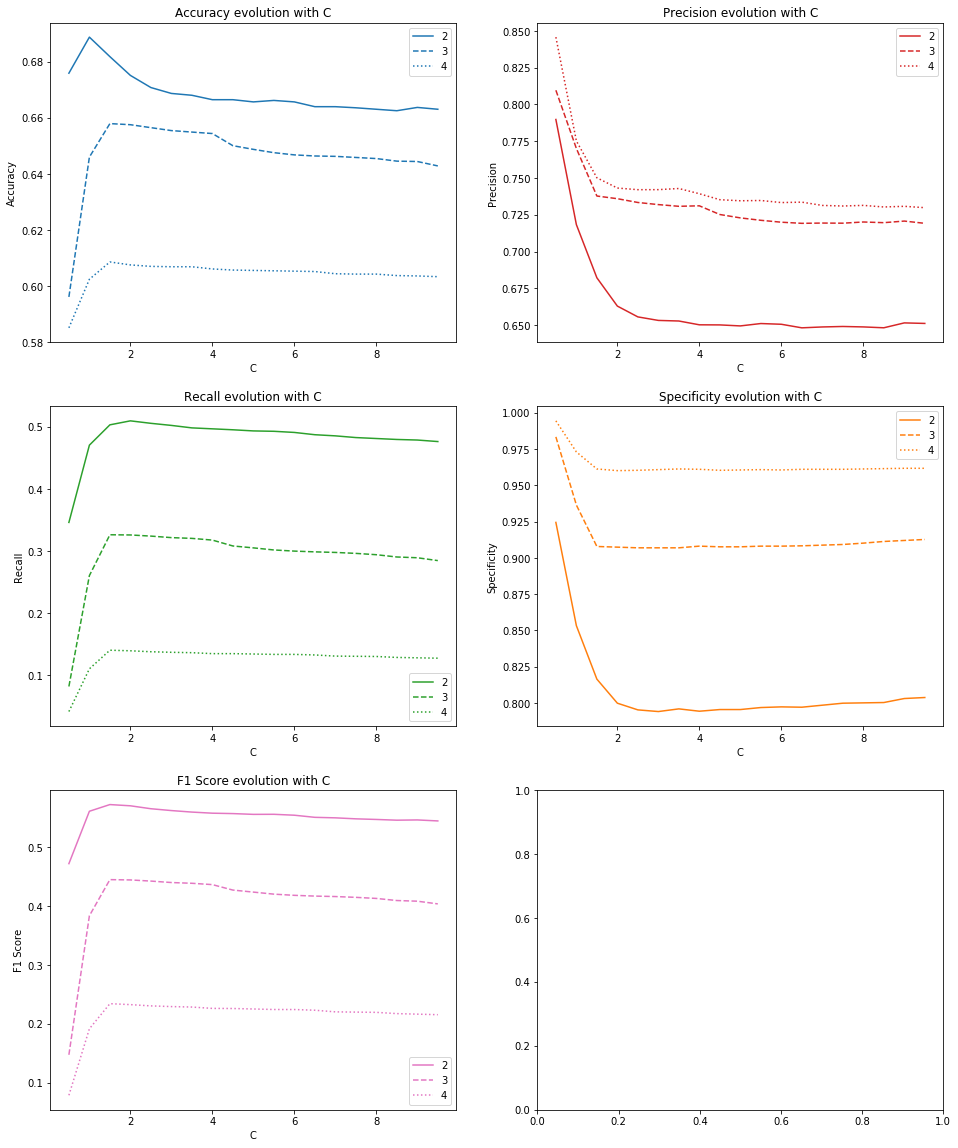

(<Figure size 1152x1440 with 6 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f816f0ba128>,
       dtype=object))

In [46]:
plot_svm_poly_performance(svm_poly_perf)

In [47]:
svm_poly_perf

kernel    C  degree                                      accuracy_fold  \
0    poly  0.5       2  [0.6730137885751806, 0.6657912015758372, 0.652...   
1    poly  0.5       3  [0.5889691398555482, 0.6073539067629679, 0.587...   
2    poly  0.5       4  [0.5738673670387393, 0.5909389363099147, 0.575...   
3    poly  1.0       2  [0.7156927117531189, 0.654629021667761, 0.6618...   
4    poly  1.0       3  [0.6408404464871963, 0.6434668417596848, 0.628...   
5    poly  1.0       4  [0.5988181221273802, 0.6014445173998687, 0.584...   
6    poly  1.5       2  [0.7019041365725541, 0.6513460275771503, 0.652...   
7    poly  1.5       3  [0.649376231122784, 0.6382140512147079, 0.6454...   
8    poly  1.5       4  [0.6047275114904793, 0.6073539067629679, 0.591...   
9    poly  2.0       2  [0.6913985554826001, 0.6487196323046619, 0.651...   
10   poly  2.0       3  [0.6487196323046619, 0.6369008535784636, 0.646...   
11   poly  2.0       4  [0.6040709126723572, 0.6060407091267236, 0.591...   
12   poly  2.5       2  [0.690741956664478, 0.63887065003283, 0.650032...   
13   poly  2.5       3  [0.6487196323046619, 0.6369008535784636, 0.644...   
14   poly  2.5       4  [0.6040709126723572, 0.6047275114904793, 0.591...   
15   poly  3.0       2  [0.690741956664478, 0.6362442547603414, 0.6500...   
16   poly  3.0       3  [0.6480630334865397, 0.6355876559422193, 0.644...   
17   poly  3.0       4  [0.6040709126723572, 0.6053841103086014, 0.590...   
18   poly  3.5       2  [0.6900853578463558, 0.6349310571240971, 0.650...   
19   poly  3.5       3  [0.6480630334865397, 0.6349310571240971, 0.644...   
20   poly  3.5       4  [0.603414313854235, 0.6040709126723572, 0.5909...   
21   poly  4.0       2  [0.6887721602101117, 0.6355876559422193, 0.649...   
22   poly  4.0       3  [0.6480630334865397, 0.6355876559422193, 0.641...   
23   poly  4.0       4  [0.603414313854235, 0.6021011162179908, 0.5896...   
24   poly  4.5       2  [0.6868023637557452, 0.6375574523965857, 0.650...   
25   poly  4.5       3  [0.6460932370321734, 0.6316480630334865, 0.640...   
26   poly  4.5       4  [0.603414313854235, 0.6021011162179908, 0.5889...   
27   poly  5.0       2  [0.685489166119501, 0.6362442547603414, 0.6487...   
28   poly  5.0       3  [0.6447800393959291, 0.6316480630334865, 0.638...   
29   poly  5.0       4  [0.602757715036113, 0.6007879185817465, 0.5896...   
30   poly  5.5       2  [0.685489166119501, 0.6362442547603414, 0.6493...   
31   poly  5.5       3  [0.6414970453053185, 0.6323046618516087, 0.638...   
32   poly  5.5       4  [0.6021011162179908, 0.6007879185817465, 0.590...   
33   poly  6.0       2  [0.685489166119501, 0.6349310571240971, 0.6500...   
34   poly  6.0       3  [0.6414970453053185, 0.6303348653972423, 0.639...   
35   poly  6.0       4  [0.6021011162179908, 0.6014445173998687, 0.590...   
36   poly  6.5       2  [0.6835193696651346, 0.6342744583059751, 0.650...   
37   poly  6.5       3  [0.6401838476690742, 0.6303348653972423, 0.640...   
38   poly  6.5       4  [0.6021011162179908, 0.6007879185817465, 0.590...   
39   poly  7.0       2  [0.6841759684832567, 0.6336178594878529, 0.650...   
40   poly  7.0       3  [0.6401838476690742, 0.629021667760998, 0.6408...   
41   poly  7.0       4  [0.6014445173998687, 0.5994747209455022, 0.590...   
42   poly  7.5       2  [0.6808929743926461, 0.6329612606697308, 0.652...   
43   poly  7.5       3  [0.639527248850952, 0.6283650689428759, 0.6401...   
44   poly  7.5       4  [0.6014445173998687, 0.5994747209455022, 0.590...   
45   poly  8.0       2  [0.6808929743926461, 0.6309914642153645, 0.652...   
46   poly  8.0       3  [0.63887065003283, 0.629021667760998, 0.638214...   
47   poly  8.0       4  [0.6014445173998687, 0.5994747209455022, 0.590...   
48   poly  8.5       2  [0.6808929743926461, 0.6309914642153645, 0.650...   
49   poly  8.5       3  [0.6382140512147079, 0.6277084701247537, 0.636...   
50   poly  8.5       4  [0.6014445173998687, 0.5988181221273802, 0.590...   

Identical conlussions can be taken for kernel poly. Grade 2 outake performance for all the models with poly kernel

#### Final global analysis

Merge all the performance records

In [73]:
# Fuse kernel & degree into one column
aux_svm_poly_perf = svm_poly_perf.copy()
aux_svm_poly_perf['kernel'] = aux_svm_poly_perf['kernel'].astype(str) + ' - degree:' + aux_svm_poly_perf['degree'].astype(str)
aux_svm_poly_perf.drop(columns='degree')

# Merge the tables in one column
svm_perf = pd.concat([svm_rbf_perf, svm_lin_perf, aux_svm_poly_perf], sort=False)

kernel    C                                      accuracy_fold  \
0               rbf  0.5  [0.7137229152987524, 0.6657912015758372, 0.680...   
1               rbf  1.0  [0.7229152987524623, 0.6671043992120814, 0.672...   
2               rbf  1.5  [0.7196323046618516, 0.6467498358502954, 0.659...   
3               rbf  2.0  [0.7176625082074852, 0.6414970453053185, 0.660...   
4               rbf  2.5  [0.7143795141168746, 0.6336178594878529, 0.657...   
..              ...  ...                                                ...   
52  poly - degree:3  9.0  [0.639527248850952, 0.6277084701247537, 0.6349...   
53  poly - degree:4  9.0  [0.6007879185817465, 0.5988181221273802, 0.589...   
54  poly - degree:2  9.5  [0.685489166119501, 0.6316480630334865, 0.6493...   
55  poly - degree:3  9.5  [0.63887065003283, 0.6270518713066316, 0.63361...   
56  poly - degree:4  9.5  [0.6007879185817465, 0.5988181221273802, 0.588...   

                                       precision_fold  \
0   [0.8454258675078864, 0.6572668112798264, 0.677...   
1   [0.8057742782152231, 0.634862385321101, 0.6324...   
2   [0.7821782178217822, 0.5989761092150171, 0.610...   
3   [0.7647058823529411, 0.5897009966777409, 0.608...   
4   [0.7546296296296297, 0.5774193548387097, 0.602...   
..                                                ...   
52  [0.7676767676767676, 0.6464646464646465, 0.661...   
53  [0.8309859154929577, 0.6546762589928058, 0.623...   
54  [0.7211055276381909, 0.5892514395393474, 0.611...   
55  [0.766497461928934, 0.6452702702702703, 0.6610...   
56  [0.8309859154929577, 0.6546762589928058, 0.620...   

                                          recall_fold  \
0   [0.40916030534351144, 0.463302752293578, 0.489...   
1   [0.4687022900763359, 0.5290519877675841, 0.565...   
2   [0.48244274809160304, 0.536697247706422, 0.573...   
3   [0.4961832061068702, 0.5428134556574924, 0.587...   
4   [0.49770992366412214, 0.5474006116207951, 0.59...   
..                                                ...   
52  [0.23206106870229007, 0.29357798165137616, 0.3...   
53  [0.0900763358778626, 0.13914373088685014, 0.11...   
54  [0.4381679389312977, 0.4694189602446483, 0.503...   
55  [0.23053435114503817, 0.29204892966360857, 0.3...   
56  [0.0900763358778626, 0.13914373088685014, 0.11...   

                                     specificity_fold  \
0   [0.9435483870967742, 0.8181818181818182, 0.825...   
1   [0.9147465437788018, 0.7710011507479861, 0.752...   
2   [0.8986175115207373, 0.7295742232451093, 0.724...   
3   [0.8847926267281107, 0.715765247410817, 0.7157...   
4   [0.8778801843317973, 0.6985040276179517, 0.705...   
..                                                ...   
52  [0.9470046082949308, 0.8791714614499425, 0.881...   
53  [0.9861751152073732, 0.9447640966628308, 0.949...   
54  [0.8721198156682027, 0.7537399309551208, 0.759...   
55  [0.9470046082949308, 0.8791714614499425, 0.883...   
56  [0.9861751152073732, 0.9447640966628308, 0.949...   

                                        f1_score_fold  accuracy_avg  \
0   [0.5514403292181069, 0.5434977578475336, 0.568...      0.699335   
1   [0.5926640926640926, 0.5771476230191828, 0.597...      0.697758   
2   [0.5967894239848914, 0.5661290322580644, 0.591...      0.685016   
3   [0.6018518518518519, 0.5652866242038217, 0.597...      0.679761   
4   [0.5998160073597056, 0.5620094191522762, 0.597...      0.675952   
..                                                ...           ...   
52  [0.3563892145369285, 0.4037854889589906, 0.419...      0.644428   
53  [0.162534435261708, 0.22950819672131148, 0.189...      0.603576   
54  [0.5451092117758785, 0.5225531914893617, 0.552...      0.663079   
55  [0.3544600938967136, 0.4021052631578948, 0.413...      0.642852   
56  [0.162534435261708, 0.22950819672131148, 0.187...      0.603313   

    accuracy_std  precision_avg  precision_std  recall_avg  recall_std  \
0       0.038382       0.765400       0.080613    0.446970    0.094429   
1       

In [81]:
with pd.option_context('display.max_rows', 100):
    display(svm_perf)

kernel    C                                      accuracy_fold  \
0               rbf  0.5  [0.7137229152987524, 0.6657912015758372, 0.680...   
1               rbf  1.0  [0.7229152987524623, 0.6671043992120814, 0.672...   
2               rbf  1.5  [0.7196323046618516, 0.6467498358502954, 0.659...   
3               rbf  2.0  [0.7176625082074852, 0.6414970453053185, 0.660...   
4               rbf  2.5  [0.7143795141168746, 0.6336178594878529, 0.657...   
5               rbf  3.0  [0.7091267235718975, 0.6336178594878529, 0.655...   
6               rbf  3.5  [0.7071569271175312, 0.6296782665791202, 0.654...   
7               rbf  4.0  [0.7058437294812869, 0.6296782665791202, 0.656...   
8               rbf  4.5  [0.7058437294812869, 0.6277084701247537, 0.656...   
9               rbf  5.0  [0.706500328299409, 0.6263952724885096, 0.6572...   
10              rbf  5.5  [0.706500328299409, 0.6244254760341431, 0.6572...   
11              rbf  6.0  [0.706500328299409, 0.6244254760341431, 0.6559...   
12              rbf  6.5  [0.7071569271175312, 0.6244254760341431, 0.655...   
13              rbf  7.0  [0.7051871306631649, 0.6231122783978988, 0.657...   
14              rbf  7.5  [0.7051871306631649, 0.6250820748522653, 0.657...   
15              rbf  8.0  [0.7051871306631649, 0.623768877216021, 0.6579...   
16              rbf  8.5  [0.7058437294812869, 0.623768877216021, 0.6592...   
17              rbf  9.0  [0.706500328299409, 0.6231122783978988, 0.6592...   
18              rbf  9.5  [0.706500328299409, 0.6231122783978988, 0.6585...   
0            linear  0.5  [0.7117531188443861, 0.6506894287590282, 0.679...   
1            linear  1.0  [0.7058437294812869, 0.6362442547603414, 0.659...   
2            linear  1.5  [0.7038739330269206, 0.6270518713066316, 0.647...   
3            linear  2.0  [0.7143795141168746, 0.6152330925804333, 0.640...   
4            linear  2.5  [0.7071569271175312, 0.6198292843072882, 0.637...   
5            linear  3.0  [0.7051871306631649, 0.6152330925804333, 0.640...   
6            linear  3.5  [0.7038739330269206, 0.6119500984898227, 0.638...   
7            linear  4.0  [0.7045305318450427, 0.6014445173998687, 0.632...   
8            linear  4.5  [0.7045305318450427, 0.6007879185817465, 0.625...   
9            linear  5.0  [0.7038739330269206, 0.5981615233092581, 0.618...   
10           linear  5.5  [0.706500328299409, 0.5988181221273802, 0.6172...   
11           linear  6.0  [0.706500328299409, 0.6040709126723572, 0.6185...   
12           linear  6.5  [0.7058437294812869, 0.5994747209455022, 0.617...   
13           linear  7.0  [0.706500328299409, 0.5961917268548916, 0.6172...   
14           linear  7.5  [0.7104399212081418, 0.592908732764281, 0.6158...   
15           linear  8.0  [0.7117531188443861, 0.5915955351280368, 0.618...   
16           linear  8.5  [0.7117531188443861, 0.587655942219304, 0.6152...   
17           linear  9.0  [0.7150361129349967, 0.5863427445830598, 0.614...   
18           linear  9.5  [0.7130663164806303, 0.5837163493105713, 0.615...   
0   poly - degree:2  0.5  [0.6730137885751806, 0.6657912015758372, 0.652...   
1   poly - degree:3  0.5  [0.5889691398555482, 0.6073539067629679, 0.587...   
2   poly - degree:4  0.5  [0.5738673670387393, 0.5909389363099147, 0.575...   
3   poly - degree:2  1.0  [0.7156927117531189, 0.654629021667761, 0.6618...   
4   poly - degree:3  1.0  [0.6408404464871963, 0.6434668417596848, 0.628...   
5   poly - degree:4  1.0  [0.5988181221273802, 0.6014445173998687, 0.584...   
6   poly - degree:2  1.5  [0.7019041365725541, 0.6513460275771503, 0.652...   
7   poly - degree:3  1.5  [0.649376231122784, 0.6382140512147079, 0.6454...   
8   poly - degree:4  1.5  [0.6047275114904793, 0.6073539067629679, 0.591...   
9   poly - degree:2  2.0  [0.6913985554826001, 0.6487196323046619, 0.651...   
10  poly - degree:3  2.0  [0.6487196323046619, 0.6369008535784636, 0.646...   
11  poly - degree:4  2.0  [0.6040709126723572, 0.60604070912672

In [58]:
def plot_svm_summ_performance(perf_df):

    fig, ax = plt.subplots(3,2, figsize=(16,20))
    groups = perf_df['kernel'].drop_duplicates()

    # Plot accuracy
    for gr in groups:
        ax[0, 0].plot(perf_df.loc[perf_df['kernel'] == gr, 'C'].values,
                      perf_df.loc[perf_df['kernel'] == gr, 'accuracy_avg'].values,
                      label=gr)
    ax[0, 0].set_xlabel('C')
    ax[0, 0].set_ylabel('Accuracy')
    ax[0, 0].legend(title='Kernel')
    ax[0, 0].set_title('Accuracy evolution against C')
    
    # Plot precision
    for gr in groups:
        ax[0, 1].plot(perf_df.loc[perf_df['kernel'] == gr, 'C'].values,
                      perf_df.loc[perf_df['kernel'] == gr, 'precision_avg'].values,
                      label=gr)
    ax[0, 1].set_xlabel('C')
    ax[0, 1].set_ylabel('Precision')
    ax[0, 1].legend(title='Kernel')
    ax[0, 1].set_title('Precision evolution against C')
    
    # Plot recall
    for gr in groups:
        ax[1, 0].plot(perf_df.loc[perf_df['kernel'] == gr, 'C'].values,
                      perf_df.loc[perf_df['kernel'] == gr, 'recall_avg'].values,
                      label=gr)
    ax[1, 0].set_xlabel('C')
    ax[1, 0].set_ylabel('Recall')
    ax[1, 0].legend(title='Kernel')
    ax[1, 0].set_title('Recall evolution against C')
    
    # Plot specificity
    for gr in groups:
        ax[1, 1].plot(perf_df.loc[perf_df['kernel'] == gr, 'C'].values,
                      perf_df.loc[perf_df['kernel'] == gr, 'specificity_avg'].values,
                      label=gr)
    ax[1, 1].set_xlabel('C')
    ax[1, 1].set_ylabel('Specificity')
    ax[1, 1].legend(title='Kernel')
    ax[1, 1].set_title('Specificity evolution against C')

    # Plot f1 score
    for gr in groups:
        ax[2, 0].plot(perf_df.loc[perf_df['kernel'] == gr, 'C'].values,
                      perf_df.loc[perf_df['kernel'] == gr, 'f1_score_avg'].values,
                      label=gr)
    ax[2, 0].set_xlabel('C')
    ax[2, 0].set_ylabel('F1 Score')
    ax[2, 0].legend(title='Kernel')
    ax[2, 0].set_title('F1 Score evolution against C')
    
    plt.show()
    return fig, ax

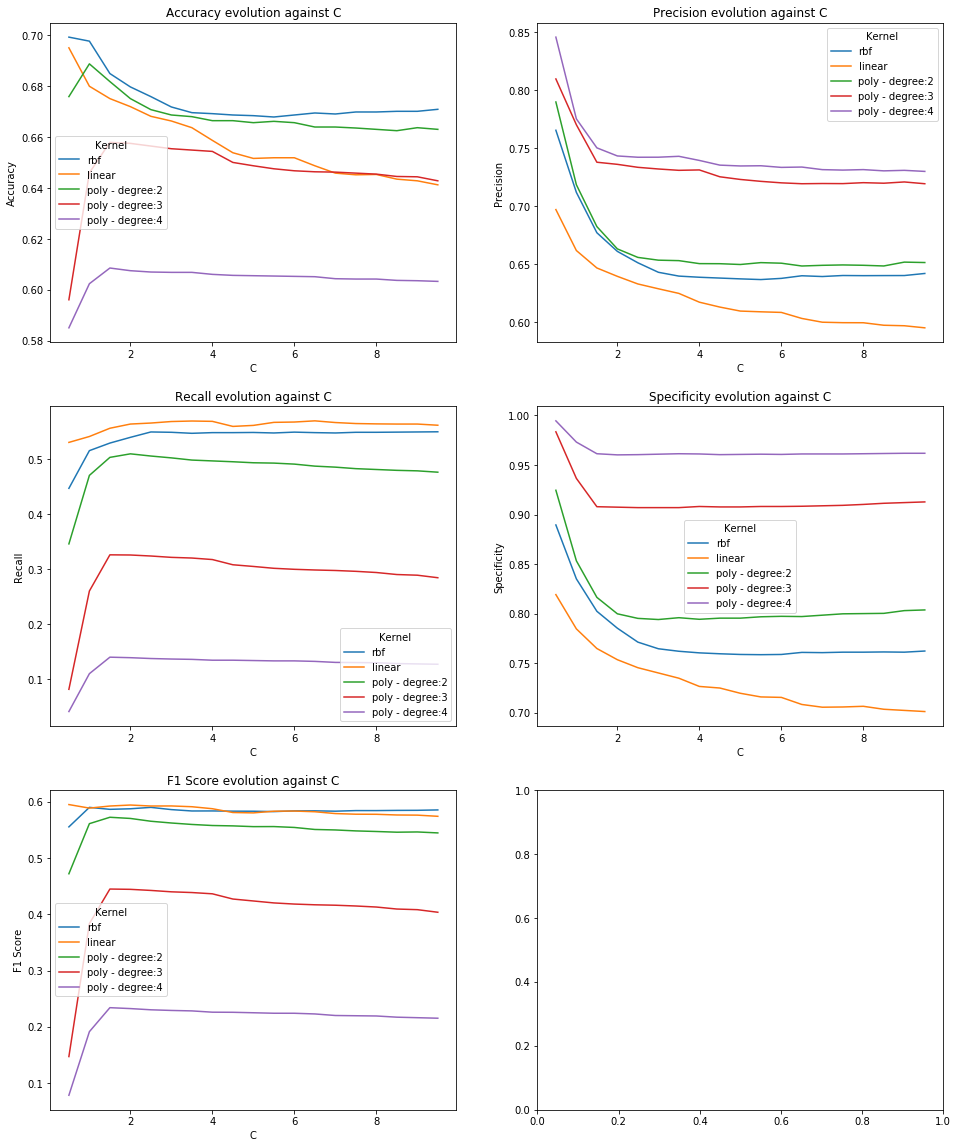

(<Figure size 1152x1440 with 6 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f816f1d5be0>,
       dtype=object))

In [75]:
plot_svm_summ_performance(svm_perf)

Model with best accuracy and f1 score

In [78]:
svm_perf.nlargest(3, 'accuracy_avg')[['C', 'kernel',
                                          'accuracy_avg',
                                          'precision_avg',
                                          'recall_avg',
                                          'specificity_avg',
                                          'f1_score_avg']]

C  kernel  accuracy_avg  precision_avg  recall_avg  specificity_avg  \
0  0.5     rbf      0.699335       0.765400    0.446970         0.889483   
1  1.0     rbf      0.697758       0.711785    0.515453         0.835133   
0  0.5  linear      0.695132       0.696957    0.530438         0.819244   

   f1_score_avg  
0      0.555507  
1      0.590161  
0      0.595133

In [79]:
svm_perf.nlargest(3, 'f1_score_avg')[['C', 'kernel',
                                          'accuracy_avg',
                                          'precision_avg',
                                          'recall_avg',
                                          'specificity_avg',
                                          'f1_score_avg']]

C  kernel  accuracy_avg  precision_avg  recall_avg  specificity_avg  \
0  0.5  linear      0.695132       0.696957    0.530438         0.819244   
3  2.0  linear      0.672014       0.639341    0.563755         0.753607   
5  3.0  linear      0.666365       0.628620    0.568342         0.740248   

   f1_score_avg  
0      0.595133  
3      0.594325  
5      0.592680

Models based on *rbf* and *linear* kernels offerts the best performances overall. In order to highlight a model, `C=0.5` and *linear* kernel offerts best average f1 score while average accuracy is closed to the best one.

### K Nearest Neighbour

Try with simples lazy model

In [82]:
from sklearn.neighbors import KNeighborsClassifier

Grid the following number of neares neighbors

In [91]:
n_neighbors = np.arange(1,204,2)
n_neighbors

array([  1,   3,   5,   7,   9,  11,  13,  15,  17,  19,  21,  23,  25,
        27,  29,  31,  33,  35,  37,  39,  41,  43,  45,  47,  49,  51,
        53,  55,  57,  59,  61,  63,  65,  67,  69,  71,  73,  75,  77,
        79,  81,  83,  85,  87,  89,  91,  93,  95,  97,  99, 101, 103,
       105, 107, 109, 111, 113, 115, 117, 119, 121, 123, 125, 127, 129,
       131, 133, 135, 137, 139, 141, 143, 145, 147, 149, 151, 153, 155,
       157, 159, 161, 163, 165, 167, 169, 171, 173, 175, 177, 179, 181,
       183, 185, 187, 189, 191, 193, 195, 197, 199, 201, 203])

In [92]:
knn_perf = [] # For saving model performance statics

for k in n_neighbors:
    np.random.seed(1)
    param = {
        'K': k,
        'accuracy_fold': [],
        'precision_fold': [],
        'recall_fold': [],
        'specificity_fold': [],
        'f1_score_fold': []
    }

    for train_index, test_index in kfold.split(X_train_vect, y_train):
    
        # Split train and test partition
        X_train_part = X_train_vect[train_index]
        y_train_part = y_train[train_index].values
        
        X_test_part = X_train_vect[test_index]
        y_test_part = y_train[test_index].values
        
        # Fit KNN model
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train_part, y_train_part)
        
        # Predict on test
        y_pred = knn.predict(X_test_part)
        
        # Meassure performance metrics
        param['accuracy_fold'].append(metrics.accuracy_score(y_test_part, y_pred))
        param['precision_fold'].append(metrics.precision_score(y_test_part, y_pred))
        param['recall_fold'].append(metrics.recall_score(y_test_part, y_pred))
        #  Exchange class 1 and 0 so measure recall for class 0 (specificity)
        param['specificity_fold'].append(metrics.recall_score(np.abs(y_test_part-1), np.abs(y_pred-1)))
        param['f1_score_fold'].append(metrics.f1_score(y_test_part, y_pred))
    
    # Compute global average metrics
    param['accuracy_avg'] = np.mean(param['accuracy_fold'])
    param['accuracy_std'] = np.std(param['accuracy_fold'])
    
    param['precision_avg'] = np.mean(param['precision_fold'])
    param['precision_std'] = np.std(param['precision_fold'])
    
    param['recall_avg'] = np.mean(param['recall_fold'])
    param['recall_std'] = np.std(param['recall_fold'])
    
    param['specificity_avg'] = np.mean(param['specificity_fold'])
    param['specificity_std'] = np.std(param['specificity_fold'])
    
    param['f1_score_avg'] = np.mean(param['f1_score_fold'])
    param['f1_score_std'] = np.std(param['f1_score_fold'])
    
    knn_perf.append(param)

knn_perf = pd.DataFrame(knn_perf)

In [93]:
knn_perf

K                                      accuracy_fold  \
0      1  [0.5804333552199606, 0.587655942219304, 0.5843...   
1      3  [0.5791201575837164, 0.5922521339461589, 0.583...   
2      5  [0.5745239658568615, 0.5935653315824031, 0.580...   
3      7  [0.5784635587655942, 0.5948785292186474, 0.581...   
4      9  [0.5810899540380827, 0.5909389363099147, 0.577...   
..   ...                                                ...   
97   195  [0.6881155613919895, 0.6657912015758372, 0.665...   
98   197  [0.6900853578463558, 0.6631648063033486, 0.667...   
99   199  [0.6913985554826001, 0.6625082074852265, 0.667...   
100  201  [0.6913985554826001, 0.6644780039395929, 0.668...   
101  203  [0.6920551543007223, 0.6664478003939593, 0.667...   

                                        precision_fold  \
0    [0.5493827160493827, 0.5663265306122449, 0.554...   
1    [0.6129032258064516, 0.6736842105263158, 0.623...   
2    [0.5309734513274337, 0.6923076923076923, 0.682...   
3    [0.6511627906976745, 0.8032786885245902, 0.766...   
4    [0.84, 0.8604651162790697, 0.7391304347826086,...   
..                                                 ...   
97   [0.7513966480446927, 0.6954177897574124, 0.712...   
98   [0.7534626038781164, 0.688, 0.716374269005848,...   
99   [0.7562326869806094, 0.6861702127659575, 0.714...   
100  [0.7562326869806094, 0.6906666666666667, 0.717...   
101  [0.7597765363128491, 0.6941489361702128, 0.715...   

                                           recall_fold  \
0    [0.13587786259541984, 0.16972477064220184, 0.1...   
1    [0.05801526717557252, 0.09785932721712538, 0.0...   
2    [0.0916030534351145, 0.0963302752293578, 0.042...   
3    [0.042748091603053436, 0.07492354740061162, 0....   
4    [0.03206106870229008, 0.05657492354740061, 0.0...   
..                                                 ...   
97   [0.41068702290076337, 0.3944954128440367, 0.37...   
98   [0.4152671755725191, 0.3944954128440367, 0.374...   
99   [0.416793893129771, 0.3944954128440367, 0.3746...   
100  [0.416793893129771, 0.39602446483180426, 0.376...   
101  [0.4152671755725191, 0.39908256880733944, 0.37...   

                                      specificity_fold  \
0    [0.9158986175115207, 0.9021864211737629, 0.901...   
1    [0.9723502304147466, 0.9643268124280783, 0.966...   
2    [0.9389400921658986, 0.9677790563866513, 0.985...   
3    [0.9827188940092166, 0.9861910241657077, 0.991...   
4    [0.9953917050691244, 0.9930955120828538, 0.993...   
..                                                 ...   
97   [0.8974654377880185, 0.8699654775604143, 0.887...   
98   [0.8974654377880185, 0.8653624856156502, 0.888...   
99   [0.8986175115207373, 0.8642117376294591, 0.887...   
100  [0.8986175115207373, 0.8665132336018412, 0.888...   
101  [0.9009216589861752, 0.8676639815880323, 0.888...   

                                         f1_score_fold  accuracy_avg  \
0    [0.21787025703794372, 0.26117647058823534, 0.2...      0.595959   
1    [0.10599721059972106, 0.17089452603471295, 0.1...      0.593331   
2    [0.15625, 0.1691275167785235, 0.08057553956834...      0.588732   
3    [0.08022922636103151, 0.13706293706293707, 0.0...      0.587680   
4    [0.061764705882352944, 0.10616929698708752, 0....      0.584527   
..                                                 ...           ...   
97   [0.531095755182626, 0.5034146341463415, 0.4884...      0.687777   
98   [0.5354330708661418, 0.5014577259475218, 0.491...      0.687382   
99   [0.5374015748031497, 0.5009708737864078, 0.491...      0.687514   
100  [0.5374015748031497, 0.5034013605442177, 0.493...      0.688827   
101  [0.5370187561697927, 0.5067961165048543, 0.490...      0.688696   

     accuracy_std  precision_avg  precision_std  recall_avg  recall_std  \
0        0.014644       0.605305       0.066655    0.174576    0.034120   
1        0.011943       0.707317       0.102782    0.092337    0.033554   
2        0.009492       0.676255       0.084871    0.087434    0.0257

Plot and compare performance against K

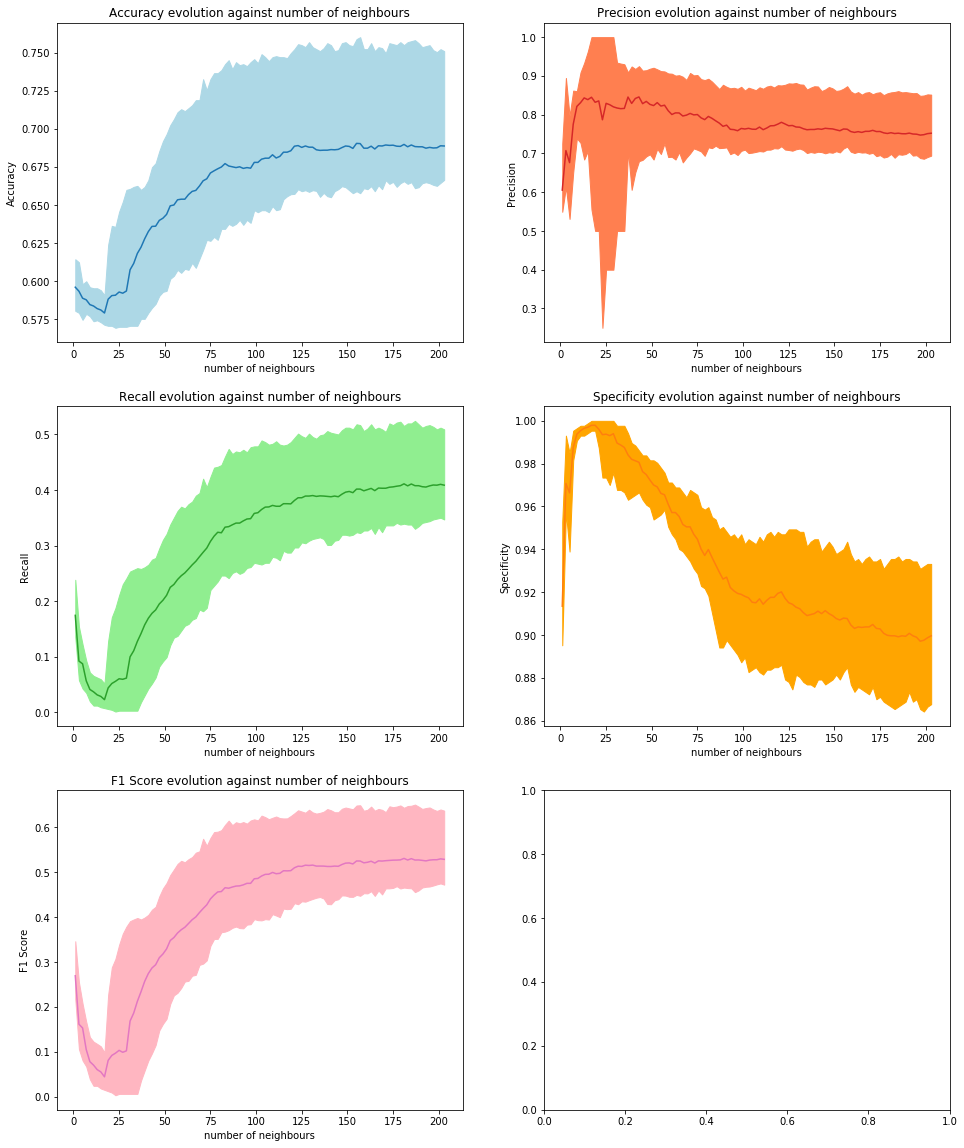

(<Figure size 1152x1440 with 6 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f816ec9f518>,
       dtype=object))

In [94]:
plot_performance(knn_perf, param='K', param_name='number of neighbours')

Models with highest accuracy and F1 Score

In [95]:
knn_perf.nlargest(3, 'accuracy_avg')[['K','accuracy_avg',
                                          'precision_avg',
                                          'recall_avg',
                                          'specificity_avg',
                                          'f1_score_avg']]

K  accuracy_avg  precision_avg  recall_avg  specificity_avg  \
77  155      0.690403       0.763021    0.401711         0.907883   
78  157      0.690272       0.762412    0.401709         0.907653   
90  181      0.689747       0.753365    0.411189         0.899596   

    f1_score_avg  
77      0.525135  
78      0.525057  
90      0.530903

In [96]:
knn_perf.nlargest(3, 'f1_score_avg')[['K','accuracy_avg',
                                          'precision_avg',
                                          'recall_avg',
                                          'specificity_avg',
                                          'f1_score_avg']]

K  accuracy_avg  precision_avg  recall_avg  specificity_avg  \
90   181      0.689747       0.753365    0.411189         0.899596   
92   185      0.689353       0.752156    0.410885         0.899135   
100  201      0.688827       0.751046    0.410270         0.898674   

     f1_score_avg  
90       0.530903  
92       0.530305  
100      0.529862

Summary points:
* When K increases, overall model performance increases until reaching plateau (except for scpecificity which suffers a loss of pediction capability towards the prediction of non-disaster tweets).
* Model with best average accuracy is obtained with `K=155` while model with best f1-score is obtained with `K=181`. I'd highlight this last one as best model as offerts a better balance prediction towards two classes with a higher f1-score while its accuracy is on the top.

### Decision Tree

Try to fit simple tree decision models 

In [25]:
from sklearn.tree import DecisionTreeClassifier

Grid following parameters:

In [26]:
# Try different maximum tree depths
max_depths = [None] + list(range(10, 500, 10))
max_depths

[None,
 10,
 20,
 30,
 40,
 50,
 60,
 70,
 80,
 90,
 100,
 110,
 120,
 130,
 140,
 150,
 160,
 170,
 180,
 190,
 200,
 210,
 220,
 230,
 240,
 250,
 260,
 270,
 280,
 290,
 300,
 310,
 320,
 330,
 340,
 350,
 360,
 370,
 380,
 390,
 400,
 410,
 420,
 430,
 440,
 450,
 460,
 470,
 480,
 490]

In [27]:
decision_tree_perf = [] # For saving model performance statics

for max_d in max_depths:
    np.random.seed(1)
    param = {
        'max_depth': max_d,
        'accuracy_fold': [],
        'precision_fold': [],
        'recall_fold': [],
        'specificity_fold': [],
        'f1_score_fold': []
    }

    for train_index, test_index in kfold.split(X_train_vect, y_train):
    
        # Split train and test partition
        X_train_part = X_train_vect[train_index]
        y_train_part = y_train[train_index].values
        
        X_test_part = X_train_vect[test_index]
        y_test_part = y_train[test_index].values
        
        # Fit Decision Tree model
        dec_tree = DecisionTreeClassifier(max_depth=max_d)
        dec_tree.fit(X_train_part, y_train_part)
        
        # Predict on test
        y_pred = dec_tree.predict(X_test_part)
        
        # Meassure performance metrics
        param['accuracy_fold'].append(metrics.accuracy_score(y_test_part, y_pred))
        param['precision_fold'].append(metrics.precision_score(y_test_part, y_pred))
        param['recall_fold'].append(metrics.recall_score(y_test_part, y_pred))
        #  Exchange class 1 and 0 so measure recall for class 0 (specificity)
        param['specificity_fold'].append(metrics.recall_score(np.abs(y_test_part-1), np.abs(y_pred-1)))
        param['f1_score_fold'].append(metrics.f1_score(y_test_part, y_pred))
    
    # Compute global average metrics
    param['accuracy_avg'] = np.mean(param['accuracy_fold'])
    param['accuracy_std'] = np.std(param['accuracy_fold'])
    
    param['precision_avg'] = np.mean(param['precision_fold'])
    param['precision_std'] = np.std(param['precision_fold'])
    
    param['recall_avg'] = np.mean(param['recall_fold'])
    param['recall_std'] = np.std(param['recall_fold'])
    
    param['specificity_avg'] = np.mean(param['specificity_fold'])
    param['specificity_std'] = np.std(param['specificity_fold'])
    
    param['f1_score_avg'] = np.mean(param['f1_score_fold'])
    param['f1_score_std'] = np.std(param['f1_score_fold'])
    
    decision_tree_perf.append(param)

decision_tree_perf = pd.DataFrame(decision_tree_perf)

Plot and compare models performance against decision max depth allowed:

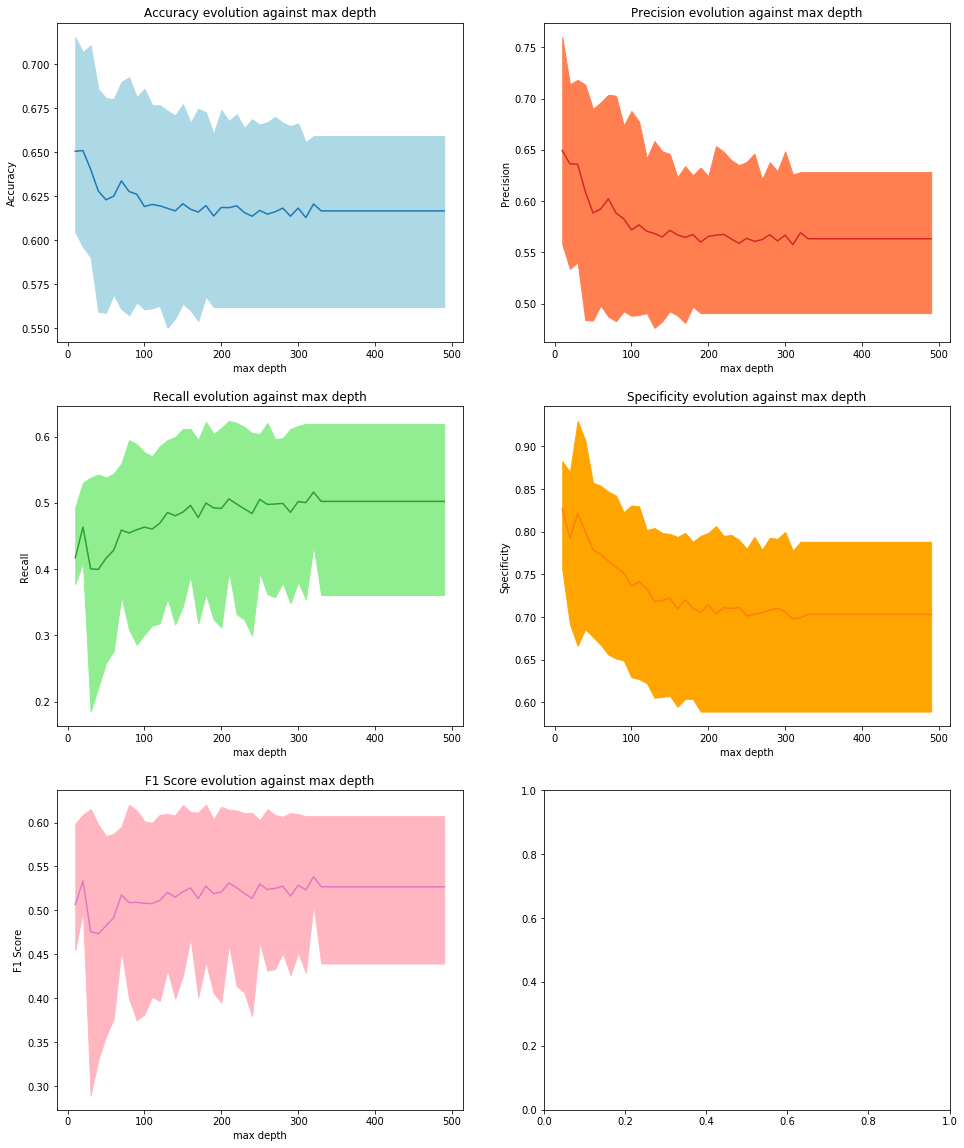

(<Figure size 1152x1440 with 6 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7effce162550>,
       dtype=object))

In [28]:
plot_performance(decision_tree_perf, param='max_depth', param_name='max depth')

In [29]:
# Show performance table
decision_tree_perf

max_depth                                      accuracy_fold  \
0         NaN  [0.6592252133946159, 0.6021011162179908, 0.562...   
1        10.0  [0.6638214051214708, 0.6047275114904793, 0.617...   
2        20.0  [0.6808929743926461, 0.6165462902166776, 0.596...   
3        30.0  [0.6835193696651346, 0.5902823374917925, 0.607...   
4        40.0  [0.685489166119501, 0.5968483256730138, 0.5594...   
5        50.0  [0.6808929743926461, 0.6040709126723572, 0.558...   
6        60.0  [0.680236375574524, 0.5994747209455022, 0.5692...   
7        70.0  [0.6900853578463558, 0.6145764937623113, 0.560...   
8        80.0  [0.6927117531188444, 0.6007879185817465, 0.557...   
9        90.0  [0.6776099803020355, 0.6172028890347997, 0.564...   
10      100.0  [0.6861457649376231, 0.5968483256730138, 0.560...   
11      110.0  [0.6769533814839134, 0.5942219304005253, 0.561...   
12      120.0  [0.6592252133946159, 0.6145764937623113, 0.562...   
13      130.0  [0.6736703873933026, 0.5961917268548916, 0.550...   
14      140.0  [0.6710439921208142, 0.5975049244911359, 0.555...   
15      150.0  [0.6651346027577151, 0.5968483256730138, 0.564...   
16      160.0  [0.6520026263952725, 0.5889691398555482, 0.560...   
17      170.0  [0.659881812212738, 0.5994747209455022, 0.5541...   
18      180.0  [0.6552856204858831, 0.5975049244911359, 0.567...   
19      190.0  [0.6605384110308602, 0.5948785292186474, 0.562...   
20      200.0  [0.6572554169402495, 0.6106369008535785, 0.562...   
21      210.0  [0.6677609980302035, 0.5981615233092581, 0.562...   
22      220.0  [0.6717005909389363, 0.6040709126723572, 0.562...   
23      230.0  [0.6638214051214708, 0.5968483256730138, 0.562...   
24      240.0  [0.6618516086671044, 0.5961917268548916, 0.562...   
25      250.0  [0.6657912015758372, 0.5915955351280368, 0.562...   
26      260.0  [0.6671043992120814, 0.5896257386736704, 0.562...   
27      270.0  [0.6559422193040052, 0.5948785292186474, 0.562...   
28      280.0  [0.659881812212738, 0.5988181221273802, 0.5620...   
29      290.0  [0.6526592252133946, 0.5922521339461589, 0.562...   
30      300.0  [0.6664478003939593, 0.5988181221273802, 0.562...   
31      310.0  [0.6552856204858831, 0.5968483256730138, 0.562...   
32      320.0  [0.6592252133946159, 0.5896257386736704, 0.562...   
33      330.0  [0.6592252133946159, 0.6021011162179908, 0.562...   
34      340.0  [0.6592252133946159, 0.6021011162179908, 0.562...   
35      350.0  [0.6592252133946159, 0.6021011162179908, 0.562...   
36      360.0  [0.6592252133946159, 0.6021011162179908, 0.562...   
37      370.0  [0.6592252133946159, 0.6021011162179908, 0.562...   
38      380.0  [0.6592252133946159, 0.6021011162179908, 0.562...   
39      390.0  [0.6592252133946159, 0.6021011162179908, 0.562...   
40      400.0  [0.6592252133946159, 0.6021011162179908, 0.562...   
41      410.0  [0.6592252133946159, 0.6021011162179908, 0.562...   
42      420.0  [0.6592252133946159, 0.6021011162179908, 0.562...   
43      430.0  [0.6592252133946159, 0.6021011162179908, 0.562...   
44      440.0  [0.6592252133946159, 0.6021011162179908, 0.562...   
45      450.0  [0.6592252133946159, 0.6021011162179908, 0.562...   
46      460.0  [0.6592252133946159, 0.6021011162179908, 0.562...   
47      470.0  [0.6592252133946159, 0.6021011162179908, 0.562...   
48      480.0  [0.6592252133946159, 0.6021011162179908, 0.562...   
49      490.0  [0.6592252133946159, 0.6021011162179908, 0.562...   

                                       precision_fold  \
0   [0.6283018867924528, 0.5398671096345515, 0.490...   
1   [0.6906666666666667, 0.5577777777777778, 0.572...   
2   [0.7139240506329114, 0.5631768953068592, 0.533...   
3   [0.7125307125307125, 0.5403225806451613, 0.544...   
4   [0.7135922330097088, 0.5421940928270043, 0.483...   
5   [0.6898876404494382, 0.5519348268839104, 0.483...   
6   [0.6962616822429907, 0.5426356589147286, 0.498...   
7   [0.7037861915367484, 0.5628517823639775, 0.487...   
8   [0.702819956616052

Highlight model with best accuray and f1-score

In [32]:
decision_tree_perf.nlargest(3, 'accuracy_avg')[['max_depth',
                                          'accuracy_avg',
                                          'precision_avg',
                                          'recall_avg',
                                          'specificity_avg',
                                          'f1_score_avg']]

max_depth  accuracy_avg  precision_avg  recall_avg  specificity_avg  \
2       20.0      0.651000       0.636374    0.463477         0.792301   
1       10.0      0.650606       0.649359    0.417004         0.826607   
3       30.0      0.640357       0.636016    0.400476         0.821090   

   f1_score_avg  
2      0.533354  
1      0.506438  
3      0.475849

In [33]:
decision_tree_perf.nlargest(3, 'f1_score_avg')[['max_depth',
                                          'accuracy_avg',
                                          'precision_avg',
                                          'recall_avg',
                                          'specificity_avg',
                                          'f1_score_avg']]

max_depth  accuracy_avg  precision_avg  recall_avg  specificity_avg  \
32      320.0      0.620656       0.569174    0.516358         0.699251   
2        20.0      0.651000       0.636374    0.463477         0.792301   
21      210.0      0.618551       0.566757    0.505968         0.703396   

    f1_score_avg  
32      0.538405  
2       0.533354  
21      0.531114

Performance evolution summary points:
* In general terms, the higher max depth leads to an accuracy and specificity (measure of prediction towards non-distaster tweets) decrease until a plateau is reachen.
* Prediction towards disaster tweets is lead to increase with the higuer max depth until a plateau is reachen.
* Overall f1 score shows a very disruptive evolution with the fewer max depth and it experiences a increases evolution until convergence into a plateau with higher max depth values.

### Random Forest

Let's try with random forest classifier ensembles:

In [34]:
from sklearn.ensemble import RandomForestClassifier

In [35]:
print('Number of columns {}'.format(X_train_vect.shape[1]))

Number of columns 1278


Try with following number of estimators

In [46]:
# First grid with different order intervals
train_params = {
        'n_estimators': list(range(25, 1025, 25)),
        'max_depth': [None] + list(range(50, 500, 50))
    }

In [47]:
train_params

{'n_estimators': [25,
  50,
  75,
  100,
  125,
  150,
  175,
  200,
  225,
  250,
  275,
  300,
  325,
  350,
  375,
  400,
  425,
  450,
  475,
  500,
  525,
  550,
  575,
  600,
  625,
  650,
  675,
  700,
  725,
  750,
  775,
  800,
  825,
  850,
  875,
  900,
  925,
  950,
  975,
  1000],
 'max_depth': [None, 50, 100, 150, 200, 250, 300, 350, 400, 450]}

In [48]:
rand_forest_perf = [] # For saving model performance statics

for p in ParameterGrid(train_params):
    np.random.seed(1)
    param = {
        'n_estimators': p['n_estimators'],
        'max depth': p['max_depth'],
        'accuracy_fold': [],
        'precision_fold': [],
        'recall_fold': [],
        'specificity_fold': [],
        'f1_score_fold': []
    }

    print('Training with following parameters: ', p)
    
    for train_index, test_index in kfold.split(X_train_vect, y_train):
    
        # Split train and test partition
        X_train_part = X_train_vect[train_index]
        y_train_part = y_train[train_index].values
        
        X_test_part = X_train_vect[test_index]
        y_test_part = y_train[test_index].values
        
        # Fit Random Forest model
        rand_forest = RandomForestClassifier(n_estimators=p['n_estimators'], max_depth=p['max_depth'])
        rand_forest.fit(X_train_part, y_train_part)
        
        # Predict on test
        y_pred = rand_forest.predict(X_test_part)
        
        # Meassure performance metrics
        param['accuracy_fold'].append(metrics.accuracy_score(y_test_part, y_pred))
        param['precision_fold'].append(metrics.precision_score(y_test_part, y_pred))
        param['recall_fold'].append(metrics.recall_score(y_test_part, y_pred))
        #  Exchange class 1 and 0 so measure recall for class 0 (specificity)
        param['specificity_fold'].append(metrics.recall_score(np.abs(y_test_part-1), np.abs(y_pred-1)))
        param['f1_score_fold'].append(metrics.f1_score(y_test_part, y_pred))
    
    # Compute global average metrics
    param['accuracy_avg'] = np.mean(param['accuracy_fold'])
    param['accuracy_std'] = np.std(param['accuracy_fold'])
    
    param['precision_avg'] = np.mean(param['precision_fold'])
    param['precision_std'] = np.std(param['precision_fold'])
    
    param['recall_avg'] = np.mean(param['recall_fold'])
    param['recall_std'] = np.std(param['recall_fold'])
    
    param['specificity_avg'] = np.mean(param['specificity_fold'])
    param['specificity_std'] = np.std(param['specificity_fold'])
    
    param['f1_score_avg'] = np.mean(param['f1_score_fold'])
    param['f1_score_std'] = np.std(param['f1_score_fold'])
    
    rand_forest_perf.append(param)

rand_forest_perf = pd.DataFrame(rand_forest_perf)

Training with following parameters:  {'max_depth': None, 'n_estimators': 25}
Training with following parameters:  {'max_depth': None, 'n_estimators': 50}
Training with following parameters:  {'max_depth': None, 'n_estimators': 75}
Training with following parameters:  {'max_depth': None, 'n_estimators': 100}
Training with following parameters:  {'max_depth': None, 'n_estimators': 125}
Training with following parameters:  {'max_depth': None, 'n_estimators': 150}
Training with following parameters:  {'max_depth': None, 'n_estimators': 175}
Training with following parameters:  {'max_depth': None, 'n_estimators': 200}
Training with following parameters:  {'max_depth': None, 'n_estimators': 225}
Training with following parameters:  {'max_depth': None, 'n_estimators': 250}
Training with following parameters:  {'max_depth': None, 'n_estimators': 275}
Training with following parameters:  {'max_depth': None, 'n_estimators': 300}
Training with following parameters:  {'max_depth': None, 'n_estimat

Training with following parameters:  {'max_depth': 100, 'n_estimators': 700}
Training with following parameters:  {'max_depth': 100, 'n_estimators': 725}
Training with following parameters:  {'max_depth': 100, 'n_estimators': 750}
Training with following parameters:  {'max_depth': 100, 'n_estimators': 775}
Training with following parameters:  {'max_depth': 100, 'n_estimators': 800}
Training with following parameters:  {'max_depth': 100, 'n_estimators': 825}
Training with following parameters:  {'max_depth': 100, 'n_estimators': 850}
Training with following parameters:  {'max_depth': 100, 'n_estimators': 875}
Training with following parameters:  {'max_depth': 100, 'n_estimators': 900}
Training with following parameters:  {'max_depth': 100, 'n_estimators': 925}
Training with following parameters:  {'max_depth': 100, 'n_estimators': 950}
Training with following parameters:  {'max_depth': 100, 'n_estimators': 975}
Training with following parameters:  {'max_depth': 100, 'n_estimators': 1000

Training with following parameters:  {'max_depth': 250, 'n_estimators': 375}
Training with following parameters:  {'max_depth': 250, 'n_estimators': 400}
Training with following parameters:  {'max_depth': 250, 'n_estimators': 425}
Training with following parameters:  {'max_depth': 250, 'n_estimators': 450}
Training with following parameters:  {'max_depth': 250, 'n_estimators': 475}
Training with following parameters:  {'max_depth': 250, 'n_estimators': 500}
Training with following parameters:  {'max_depth': 250, 'n_estimators': 525}
Training with following parameters:  {'max_depth': 250, 'n_estimators': 550}
Training with following parameters:  {'max_depth': 250, 'n_estimators': 575}
Training with following parameters:  {'max_depth': 250, 'n_estimators': 600}
Training with following parameters:  {'max_depth': 250, 'n_estimators': 625}
Training with following parameters:  {'max_depth': 250, 'n_estimators': 650}
Training with following parameters:  {'max_depth': 250, 'n_estimators': 675}

Training with following parameters:  {'max_depth': 400, 'n_estimators': 50}
Training with following parameters:  {'max_depth': 400, 'n_estimators': 75}
Training with following parameters:  {'max_depth': 400, 'n_estimators': 100}
Training with following parameters:  {'max_depth': 400, 'n_estimators': 125}
Training with following parameters:  {'max_depth': 400, 'n_estimators': 150}
Training with following parameters:  {'max_depth': 400, 'n_estimators': 175}
Training with following parameters:  {'max_depth': 400, 'n_estimators': 200}
Training with following parameters:  {'max_depth': 400, 'n_estimators': 225}
Training with following parameters:  {'max_depth': 400, 'n_estimators': 250}
Training with following parameters:  {'max_depth': 400, 'n_estimators': 275}
Training with following parameters:  {'max_depth': 400, 'n_estimators': 300}
Training with following parameters:  {'max_depth': 400, 'n_estimators': 325}
Training with following parameters:  {'max_depth': 400, 'n_estimators': 350}
T

Plot and compare model performance against parameter `n_estimators`

In [49]:
rand_forest_perf.to_csv(path_or_buf='random_forest.csv', sep=';')

In [57]:
def plot_rand_forest_perf(perf_df):

    fig, ax = plt.subplots(3,2, figsize=(16,20))
    groups = perf_df['max depth'].drop_duplicates()

    # Plot accuracy
    for gr in groups:
        ax[0, 0].plot(perf_df.loc[perf_df['max depth'] == gr, 'n_estimators'].values,
                      perf_df.loc[perf_df['max depth'] == gr, 'accuracy_avg'].values,
                      label=gr)
    ax[0, 0].set_xlabel('Num estimators')
    ax[0, 0].set_ylabel('Accuracy')
    ax[0, 0].legend(title='Max depth')
    ax[0, 0].set_title('Accuracy evolution against num estimators')
    
    # Plot precision
    for gr in groups:
        ax[0, 1].plot(perf_df.loc[perf_df['max depth'] == gr, 'n_estimators'].values,
                      perf_df.loc[perf_df['max depth'] == gr, 'precision_avg'].values,
                      label=gr)
    ax[0, 1].set_xlabel('Num estimators')
    ax[0, 1].set_ylabel('Precision')
    ax[0, 1].legend(title='Max depth')
    ax[0, 1].set_title('Precision evolution against num estimators')
    
    # Plot recall
    for gr in groups:
        ax[1, 0].plot(perf_df.loc[perf_df['max depth'] == gr, 'n_estimators'].values,
                      perf_df.loc[perf_df['max depth'] == gr, 'recall_avg'].values,
                      label=gr)
    ax[1, 0].set_xlabel('Num estimators')
    ax[1, 0].set_ylabel('Recall')
    ax[1, 0].legend(title='Max depth')
    ax[1, 0].set_title('Recall evolution against num estimators')
    
    # Plot specificity
    for gr in groups:
        ax[1, 1].plot(perf_df.loc[perf_df['max depth'] == gr, 'n_estimators'].values,
                      perf_df.loc[perf_df['max depth'] == gr, 'specificity_avg'].values,
                      label=gr)
    ax[1, 1].set_xlabel('Num estimators')
    ax[1, 1].set_ylabel('Specificity')
    ax[1, 1].legend(title='Max depth')
    ax[1, 1].set_title('Specificity evolution against num estimators')

    # Plot f1 score
    for gr in groups:
        ax[2, 0].plot(perf_df.loc[perf_df['max depth'] == gr, 'n_estimators'].values,
                      perf_df.loc[perf_df['max depth'] == gr, 'f1_score_avg'].values,
                      label=gr)
    ax[2, 0].set_xlabel('Num estimators')
    ax[2, 0].set_ylabel('F1 Score')
    ax[2, 0].legend(title='Max depth')
    ax[2, 0].set_title('F1 Score evolution against num estimators')
    
    plt.show()
    return fig, ax

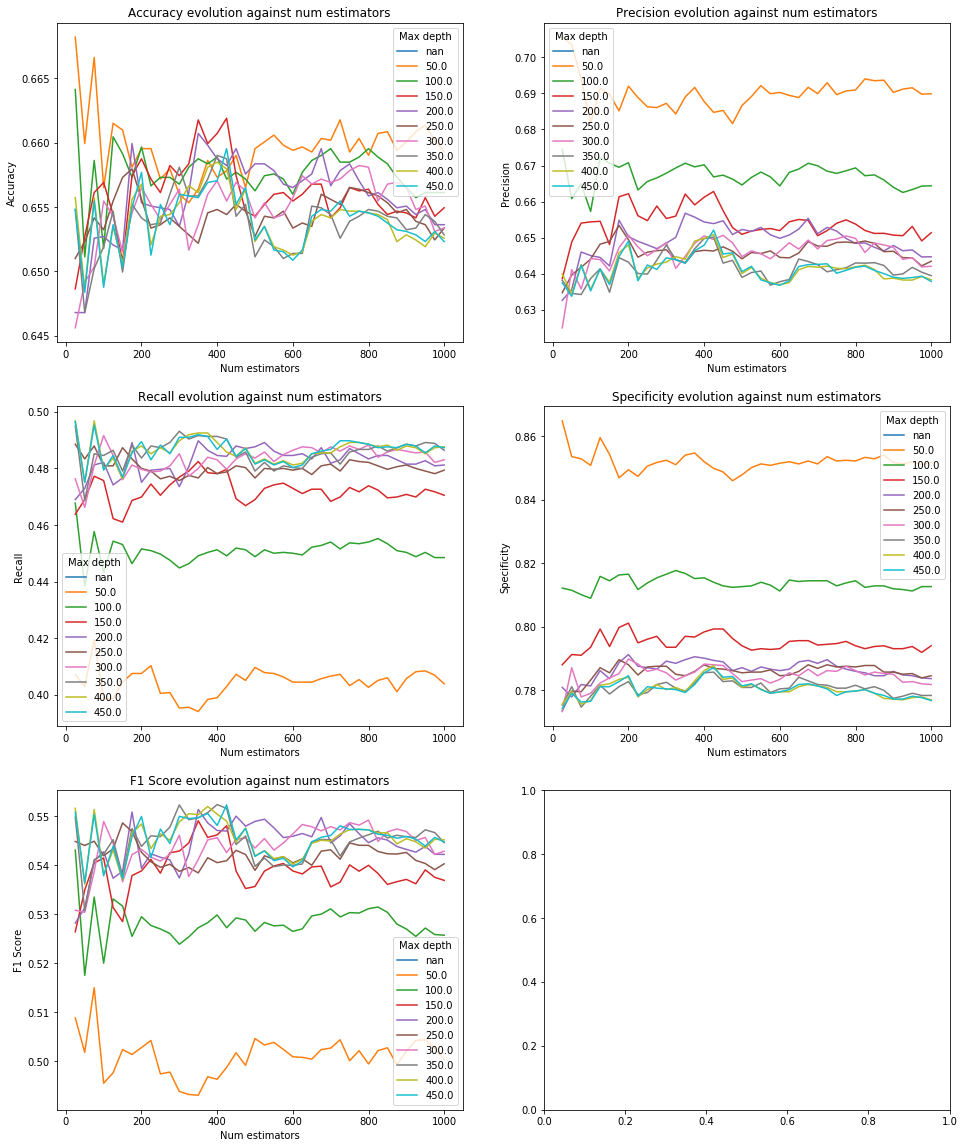

(<Figure size 1152x1440 with 6 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7effcee0f860>,
       dtype=object))

In [58]:
plot_rand_forest_perf(rand_forest_perf)

In [59]:
rand_forest_perf

n_estimators  max depth  \
0              25        NaN   
1              50        NaN   
2              75        NaN   
3             100        NaN   
4             125        NaN   
..            ...        ...   
395           900      450.0   
396           925      450.0   
397           950      450.0   
398           975      450.0   
399          1000      450.0   

                                         accuracy_fold  \
0    [0.695994747209455, 0.6172028890347997, 0.5942...   
1    [0.6953381483913329, 0.6021011162179908, 0.576...   
2    [0.6986211424819435, 0.6073539067629679, 0.595...   
3    [0.7045305318450427, 0.602757715036113, 0.5863...   
4    [0.7005909389363099, 0.613263296126067, 0.5863...   
..                                                 ...   
395  [0.7019041365725541, 0.6099803020354564, 0.583...   
396  [0.7019041365725541, 0.6086671043992121, 0.585...   
397  [0.7005909389363099, 0.6093237032173342, 0.584...   
398  [0.701247537754432, 0.6106369008535785, 0.5837...   
399  [0.7019041365725541, 0.6099803020354564, 0.583...   

                                        precision_fold  \
0    [0.7474226804123711, 0.5661080074487895, 0.526...   
1    [0.7588075880758808, 0.5463320463320464, 0.506...   
2    [0.7692307692307693, 0.5522388059701493, 0.526...   
3    [0.779291553133515, 0.5463137996219282, 0.5169...   
4    [0.7667560321715817, 0.5616698292220114, 0.516...   
..                                                 ...   
395  [0.7637795275590551, 0.5566037735849056, 0.514...   
396  [0.7637795275590551, 0.5549242424242424, 0.515...   
397  [0.762532981530343, 0.5559772296015181, 0.5147...   
398  [0.7631578947368421, 0.5574387947269304, 0.514...   
399  [0.7637795275590551, 0.5570342205323194, 0.514...   

                                           recall_fold  \
0    [0.44274809160305345, 0.4648318042813456, 0.55...   
1    [0.42748091603053434, 0.4327217125382263, 0.52...   
2    [0.42748091603053434, 0.4525993883792049, 0.57...   
3    [0.4366412213740458, 0.4418960244648318, 0.559...   
4    [0.4366412213740458, 0.4525993883792049, 0.561...   
..                                                 ...   
395  [0.4442748091603053, 0.4510703363914373, 0.561...   
396  [0.4442748091603053, 0.44801223241590216, 0.56...   
397  [0.44122137404580153, 0.44801223241590216, 0.5...   
398  [0.44274809160305345, 0.4525993883792049, 0.55...   
399  [0.4442748091603053, 0.44801223241590216, 0.55...   

                                      specificity_fold  \
0    [0.8870967741935484, 0.7318757192174914, 0.622...   
1    [0.8974654377880185, 0.7295742232451093, 0.614...   
2    [0.9032258064516129, 0.7238204833141542, 0.609...   
3    [0.9066820276497696, 0.7238204833141542, 0.606...   
4    [0.8997695852534562, 0.7341772151898734, 0.605...   
..                                                 ...   
395  [0.8963133640552995, 0.7295742232451093, 0.600...   
396  [0.8963133640552995, 0.7295742232451093, 0.601...   
397  [0.8963133640552995, 0.7307249712313003, 0.601...   
398  [0.8963133640552995, 0.7295742232451093, 0.601...   
399  [0.8963133640552995, 0.7318757192174914, 0.601...   

                                         f1_score_fold  accuracy_avg  \
0    [0.5560882070949185, 0.5104953820319059, 0.540...      0.654677   
1    [0.546875, 0.48293515358361777, 0.516129032258...      0.649162   
2    [0.5495583905789991, 0.4974789915966386, 0.550...      0.655466   
3    [0.5596868884540117, 0.4885883347421809, 0.537...      0.648634   
4    [0.556420233463035, 0.5012701100762066, 0.5381...      0.654021   
..                                                 ...           ...   
395  [0.5617760617760618, 0.4983108108108108, 0.536...      0.653102   
396  [0.5617760617760618, 0.4957698815566836, 0.538...      0.652839   
397  [0.5589941972920697, 0.4961896697713803, 0.536...      0.652313   
398  [0.5603864734299517, 0.4995780590717299, 0.535...      0.653102   
399  [0.5617760617760618, 0.496610169491

Highlight models with greatest accuracy and f1-score

In [61]:
rand_forest_perf.nlargest(3, 'accuracy_avg')[['n_estimators',
                                              'max depth',
                                          'accuracy_avg',
                                          'precision_avg',
                                          'recall_avg',
                                          'specificity_avg',
                                          'f1_score_avg']]

n_estimators  max depth  accuracy_avg  precision_avg  recall_avg  \
40            25       50.0      0.668206       0.705572    0.407219   
42            75       50.0      0.666631       0.694005    0.419461   
80            25      100.0      0.664137       0.674530    0.467765   

    specificity_avg  f1_score_avg  
40         0.864847      0.508820  
42         0.852873      0.514973  
80         0.812120      0.543049

In [62]:
rand_forest_perf.nlargest(3, 'f1_score_avg')[['n_estimators',
                                              'max depth',
                                          'accuracy_avg',
                                          'precision_avg',
                                          'recall_avg',
                                          'specificity_avg',
                                          'f1_score_avg']]

n_estimators  max depth  accuracy_avg  precision_avg  recall_avg  \
295           400      350.0      0.659014       0.649748    0.491302   
376           425      450.0      0.659539       0.652102    0.490385   
291           300      350.0      0.658094       0.647974    0.493139   

     specificity_avg  f1_score_avg  
295         0.785403      0.552355  
376         0.787016      0.552281  
291         0.782410      0.552278

Model performance evolution poses different evolutions schemas for the different `max_depth` parameters and for the different metrics. It's difficult to extract a clear tend in the performance evolution against both parameters.

In another vein, model with best accuracy is obtained when `n_estimators=25` and `max_depth=50` while the best f1-score is obtained for `n_estimators=400` and `max_depth=350`.

### XGBoost Models

Let's try finally with XGBoost models.

Following parameters will be evaluated:

In [75]:
from xgboost import XGBClassifier

In [78]:
params = {
        'max_depth': (2, 4, 6, 8),
        'eta': np.logspace(start=-5, stop=1, num=8),
        'num_round': np.around(np.logspace(start=2, stop=7, num=10, base=2)).astype('int32')
    }
params

{'max_depth': (2, 4, 6, 8),
 'eta': array([1.00000000e-05, 7.19685673e-05, 5.17947468e-04, 3.72759372e-03,
        2.68269580e-02, 1.93069773e-01, 1.38949549e+00, 1.00000000e+01]),
 'num_round': array([  4,   6,   9,  13,  19,  27,  40,  59,  87, 128], dtype=int32)}

In [80]:
# Prepare validation through k-fold
xgb_perf = [] # To Save model performance statics

for p in ParameterGrid(params):
    np.random.seed(1)
    p.update({'objective': 'binary:logistic'})
    param = {
        'max_depth': p['max_depth'],
        'eta': p['eta'],
        'objective': p['objective'],
        'num_round': p['num_round'],
        'accuracy_fold': [],
        'precision_fold': [],
        'recall_fold': [],
        'specificity_fold': [],
        'f1_score_fold': []
    }
    
    print('Training with parameters: ', p)

    for train_index, test_index in kfold.split(X_train_vect, y_train):
    
        # Split train and test partition
        X_train_part = X_train_vect[train_index]
        y_train_part = y_train[train_index].values
        
        X_test_part = X_train_vect[test_index]
        y_test_part = y_train[test_index].values
        
        # Fit XGBoost model
        xgb = XGBClassifier(**p)
        xgb.fit(X_train_part, y_train_part)
        
        # Predict over test
        y_pred = xgb.predict(X_test_part)
        
        # Meassure performance metrics
        param['accuracy_fold'].append(metrics.accuracy_score(y_test_part, y_pred))
        param['precision_fold'].append(metrics.precision_score(y_test_part, y_pred))
        param['recall_fold'].append(metrics.recall_score(y_test_part, y_pred))
        #  Exchange class 1 and 0 so measure recall for class 0 (specificity)
        param['specificity_fold'].append(metrics.recall_score(np.abs(y_test_part-1), np.abs(y_pred-1)))
        param['f1_score_fold'].append(metrics.f1_score(y_test_part, y_pred))
    
    # Compute global average metrics
    param['accuracy_avg'] = np.mean(param['accuracy_fold'])
    param['accuracy_std'] = np.std(param['accuracy_fold'])
    
    param['precision_avg'] = np.mean(param['precision_fold'])
    param['precision_std'] = np.std(param['precision_fold'])
    
    param['recall_avg'] = np.mean(param['recall_fold'])
    param['recall_std'] = np.std(param['recall_fold'])
    
    param['specificity_avg'] = np.mean(param['specificity_fold'])
    param['specificity_std'] = np.std(param['specificity_fold'])
    
    param['f1_score_avg'] = np.mean(param['f1_score_fold'])
    param['f1_score_std'] = np.std(param['f1_score_fold'])
    
    xgb_perf.append(param)

xgb_perf = pd.DataFrame(xgb_perf)

Training with parameters:  {'eta': 1e-05, 'max_depth': 2, 'num_round': 4, 'objective': 'binary:logistic'}
[18:49:46] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:49:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:49:46] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:49:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:49:47] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:49:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:49:47] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:49:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:49:48] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:49:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:49:49] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:49:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:49:49] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:49:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:49:50] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:49:50] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:49:50] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:49:50] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:49:50] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:49:50] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:49:51] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:49:51] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:49:52] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:49:52] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:49:52] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:49:52] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:49:53] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:49:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:49:53] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:49:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:49:54] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:49:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:49:54] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:49:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:49:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:49:55] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:49:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:49:55] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in langua

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:49:56] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:49:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:49:56] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:49:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:49:57] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:49:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:49:57] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:49:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:49:59] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:49:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:49:59] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:49:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:50:01] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:50:01] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:50:02] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:50:03] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:50:04] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:50:05] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:05] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:50:06] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:50:07] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:07] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:50:08] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:50:08] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:50:10] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:50:11] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:50:12] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:12] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:50:13] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:13] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:50:14] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:50:14] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:50:16] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:16] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:50:17] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:50:19] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:19] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:50:19] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:19] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:50:21] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:50:22] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:50:24] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:24] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:50:24] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:24] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:50:27] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:50:27] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:50:29] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:50:30] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:50:32] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:50:32] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:50:35] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:50:35] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:50:37] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:50:38] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:50:40] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:50:41] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:50:43] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:50:44] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:44] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:50:46] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:50:47] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:50:50] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:50] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:50:50] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:50] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:50:53] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:50:54] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:50:56] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:50:57] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:51:00] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:51:00] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:51:00] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:51:00] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:51:03] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:51:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:51:04] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:51:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:51:06] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:51:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:51:07] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:51:07] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:51:10] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:51:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:51:10] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:51:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:51:13] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:51:13] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:51:13] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:51:13] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[18:51:16] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:51:16] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:51:16] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:51:16] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default ev

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:51:17] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:51:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:51:17] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:51:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:51:18] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:51:18] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:51:19] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:51:19] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:51:19] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:51:19] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:51:20] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:51:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:51:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:51:20] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:51:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:51:21] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in langua

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:51:21] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:51:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:51:22] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:51:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:51:23] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:51:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:51:23] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:51:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:51:23] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:51:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:51:24] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:51:24] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:51:25] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:51:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:51:25] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:51:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:51:26] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:51:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:51:26] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:51:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:51:27] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:51:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:51:27] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:51:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:51:29] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:51:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:51:29] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:51:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:51:30] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:51:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:51:31] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:51:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:51:32] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:51:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:51:33] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:51:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:51:34] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:51:34] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:51:34] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:51:34] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:51:36] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:51:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:51:36] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:51:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:51:38] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:51:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:51:38] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:51:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:51:40] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:51:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:51:40] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:51:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:51:41] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:51:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:51:42] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:51:42] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:51:44] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:51:44] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:51:44] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:51:44] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:51:46] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:51:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:51:46] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:51:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:51:49] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:51:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:51:49] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:51:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:51:52] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:51:52] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:51:52] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:51:52] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:51:54] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:51:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:51:55] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:51:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:51:57] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:51:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:51:57] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:51:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:51:59] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:51:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:52:00] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:52:00] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:52:02] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:52:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:52:02] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:52:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:52:04] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:52:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:52:05] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:52:05] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:52:07] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:52:07] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:52:08] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:52:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:52:10] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:52:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:52:10] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:52:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:52:12] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:52:12] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:52:13] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:52:13] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:52:16] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:52:16] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:52:16] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:52:16] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:52:19] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:52:19] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:52:19] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:52:19] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:52:22] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:52:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:52:23] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:52:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:52:25] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:52:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:52:26] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:52:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:52:28] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:52:28] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:52:29] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:52:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:52:32] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:52:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:52:32] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:52:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:52:35] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:52:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:52:35] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:52:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:52:38] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:52:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:52:39] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:52:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:52:41] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:52:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:52:42] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:52:42] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:52:44] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:52:44] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:52:44] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:52:44] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:52:45] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:52:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:52:45] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:52:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:52:46] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:52:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:52:46] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:52:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:52:46] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:52:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:52:46] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:52:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:52:47] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:52:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:52:47] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:52:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:52:48] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:52:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:52:48] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:52:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:52:49] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:52:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:52:49] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:52:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:52:49] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:52:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:52:50] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:52:50] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:52:50] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:52:50] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:52:51] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:52:51] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:52:51] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:52:51] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:52:51] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:52:51] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:52:52] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:52:52] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:52:52] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:52:52] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:52:53] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:52:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:52:54] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:52:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:52:55] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:52:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:52:55] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:52:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:52:56] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:52:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:52:56] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:52:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:52:58] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:52:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:52:58] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:52:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:52:59] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:52:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:52:59] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:52:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:53:01] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:53:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:53:01] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:53:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:53:02] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:53:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:53:02] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:53:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:53:03] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:53:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:53:04] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:53:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:53:05] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:53:05] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:53:05] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:53:05] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:53:06] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:53:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:53:06] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:53:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:53:08] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:53:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:53:08] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:53:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:53:10] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:53:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:53:10] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:53:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:53:12] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:53:12] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:53:12] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:53:12] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:53:14] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:53:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:53:14] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:53:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:53:16] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:53:16] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:53:16] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:53:16] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:53:18] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:53:18] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:53:19] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:53:19] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:53:21] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:53:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:53:21] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:53:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:53:23] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:53:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:53:23] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:53:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:53:25] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:53:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:53:25] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:53:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:53:27] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:53:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:53:28] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:53:28] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:53:30] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:53:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:53:30] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:53:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:53:32] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:53:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:53:33] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:53:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:53:35] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:53:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:53:36] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:53:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:53:38] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:53:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:53:38] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:53:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:53:40] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:53:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:53:41] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:53:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:53:43] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:53:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:53:43] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:53:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:53:45] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:53:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:53:46] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:53:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:53:48] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:53:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:53:49] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:53:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:53:50] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:53:50] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:53:51] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:53:51] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:53:53] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:53:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:53:53] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:53:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:53:54] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:53:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:53:54] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:53:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:53:55] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:53:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:53:55] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:53:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:53:55] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:53:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:53:55] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:53:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:53:56] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:53:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:53:56] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:53:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:53:57] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:53:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:53:57] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:53:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:53:58] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:53:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:53:58] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:53:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:53:58] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:53:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:53:59] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:53:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:53:59] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:53:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:53:59] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:53:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:54:00] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:54:00] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:54:00] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:54:00] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:54:01] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:54:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:54:01] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:54:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:54:02] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:54:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:54:03] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:54:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:54:04] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:54:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:54:04] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:54:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:54:05] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:54:05] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:54:06] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:54:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:54:07] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:54:07] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:54:07] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:54:07] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:54:09] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:54:09] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:54:09] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:54:09] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:54:10] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:54:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:54:10] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:54:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:54:12] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:54:12] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:54:12] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:54:12] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:54:13] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:54:13] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:54:14] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:54:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:54:15] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:54:15] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:54:15] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:54:15] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:54:17] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:54:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:54:17] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:54:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:54:19] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:54:19] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:54:19] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:54:19] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:54:21] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:54:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:54:21] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:54:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:54:23] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:54:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:54:23] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:54:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:54:25] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:54:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:54:25] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:54:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:54:27] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:54:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:54:27] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:54:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:54:29] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:54:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:54:30] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:54:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:54:32] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:54:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:54:32] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:54:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:54:34] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:54:34] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:54:34] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:54:34] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:54:36] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:54:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:54:36] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:54:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:54:38] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:54:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:54:39] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:54:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:54:41] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:54:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:54:41] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:54:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:54:43] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:54:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:54:43] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:54:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:54:45] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:54:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:54:46] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:54:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:54:48] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:54:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:54:48] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:54:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:54:50] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:54:50] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:54:51] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:54:51] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:54:53] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:54:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:54:53] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:54:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:54:56] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:54:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:54:56] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:54:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:54:58] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:54:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:54:59] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:54:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:55:01] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:55:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:02] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:55:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:55:03] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:55:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:04] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:55:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:55:04] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:55:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:04] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:55:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:55:05] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:55:05] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:05] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:55:05] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:55:06] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:55:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:06] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:55:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:55:07] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:55:07] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:07] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:55:07] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:55:08] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:55:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:08] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:55:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:55:09] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:55:09] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:09] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:55:09] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:55:09] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:55:09] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:09] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:55:09] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:55:10] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:55:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:11] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:55:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:55:11] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:55:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:11] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:55:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:55:12] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:55:12] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:12] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:55:12] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:55:13] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:55:13] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:14] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:55:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:55:15] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:55:15] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:15] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:55:15] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:55:16] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:55:16] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:16] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:55:16] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:55:18] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:55:18] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:18] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:55:18] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:55:19] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:55:19] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:20] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:55:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:55:21] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:55:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:21] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:55:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:55:22] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:55:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:23] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:55:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:55:24] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:55:24] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:24] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:55:24] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:55:25] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:55:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:25] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:55:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:55:27] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:55:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:27] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:55:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:55:29] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:55:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:29] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:55:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:55:31] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:55:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:32] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:55:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:55:33] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:55:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:34] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:55:34] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:55:36] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:55:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:36] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:55:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:55:38] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:55:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:39] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:55:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:55:40] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:55:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:41] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:55:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:55:42] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:55:42] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:43] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:55:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:55:44] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:55:44] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:45] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:55:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:55:46] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:55:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:47] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:55:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:55:49] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:55:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:49] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:55:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:55:51] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:55:51] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:52] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:55:52] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:55:54] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:55:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:54] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:55:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:55:56] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:55:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:56] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:55:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:55:59] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:55:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:59] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:55:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:56:01] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:02] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:56:04] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:04] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:05] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:56:07] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:07] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:07] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:07] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:56:10] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:10] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:56:12] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:12] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:13] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:13] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:56:15] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:15] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:15] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:15] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:56:16] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:16] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:16] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:16] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:56:17] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:17] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:56:17] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:17] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:56:18] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:18] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:18] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:18] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:56:19] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:19] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:19] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:19] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:56:20] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:20] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:56:21] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:21] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:56:21] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:21] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:56:22] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:22] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:56:23] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:23] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:56:24] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:24] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:24] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:24] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:56:25] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:26] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:56:27] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:27] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:56:28] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:28] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:28] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:28] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:56:29] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:30] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:56:31] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:31] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:56:32] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:33] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:56:34] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:34] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:34] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:34] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:56:35] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:36] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:56:37] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:37] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:56:39] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:39] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:56:41] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:41] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:56:43] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:43] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:56:45] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:45] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:56:47] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:47] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:56:49] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:49] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:56:51] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:51] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:51] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:51] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:56:52] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:52] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:53] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:56:54] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:55] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:56:56] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:57] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:56:59] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:59] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:57:01] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:02] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:57:04] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:04] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:57:06] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:07] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:07] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:57:09] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:09] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:10] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:57:12] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:12] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:12] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:12] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:57:14] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:15] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:15] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:57:17] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:17] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:57:20] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:20] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:57:22] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:22] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:57:23] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:23] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:57:24] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:24] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:24] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:24] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:57:24] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:24] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:24] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:24] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:57:25] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:25] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:57:26] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:26] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:57:27] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:27] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:57:27] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:28] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:28] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:57:28] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:28] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:28] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:28] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:57:29] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:29] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:57:30] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:30] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:57:31] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:31] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:57:32] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:33] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:57:34] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:34] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:34] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:34] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:57:35] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:35] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:57:36] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:37] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:57:38] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:38] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:57:39] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:39] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:57:40] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:41] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:57:42] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:42] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:42] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:42] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:57:43] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:43] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:57:45] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:45] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:57:47] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:47] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:57:48] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:49] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:57:50] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:50] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:51] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:51] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:57:52] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:52] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:52] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:52] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:57:54] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:54] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:57:56] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:56] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:57:57] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:58] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:57:59] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:58:00] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:00] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:58:01] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:58:02] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:58:03] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:58:04] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:58:06] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:58:06] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:58:08] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:58:08] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:58:10] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:58:11] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:58:12] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:12] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:58:13] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:13] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:58:15] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:15] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:58:15] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:15] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:58:17] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:58:17] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:58:19] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:19] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:58:20] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:58:22] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:58:22] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:58:24] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:24] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training with parameters:  {'eta': 10.0, 'max_depth': 2, 'num_round': 6, 'objective': 'binary:logistic'}
[18:58:24] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you f

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:58:24] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:24] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:58:24] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:24] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:58:24] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:24] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:58:24] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:24] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:58:24] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:24] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training with parameters:  {'eta': 10.0, 'max_depth': 2, 'num_round': 19, 'objective': 'binary:logistic'}
[18:58:25] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you 

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:58:25] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:58:25] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:58:25] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:58:25] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:58:25] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:58:25] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:58:26] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training with parameters:  {'eta': 10.0, 'max_depth': 2, 'num_round': 87, 'objective': 'binary:logistic'}
[18:58:26] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you 

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:58:26] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:58:26] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:58:26] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:58:26] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:58:26] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:58:27] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:58:27] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training with parameters:  {'eta': 10.0, 'max_depth': 4, 'num_round': 9, 'objective': 'binary:logistic'}
[18:58:27] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you f

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:58:27] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:58:27] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:58:27] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:58:28] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:28] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:58:28] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:58:28] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:28] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:58:28] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in langua

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:58:28] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:28] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:58:28] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:28] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:58:28] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:28] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:58:28] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:28] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:58:29] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training with parameters:  {'eta': 10.0, 'max_depth': 4, 'num_round': 87, 'objective': 'binary:logistic'}
[18:58:29] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you 

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:58:29] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:58:29] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:58:29] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:58:29] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/nico/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[18:58:30] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:58:30] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/nico/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[18:58:30] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:58:30] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/nico/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[18:58:30] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:58:30] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/nico/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[18:58:31] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:58:31] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/nico/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[18:58:31] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:58:31] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/nico/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[18:58:31] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:58:31] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/nico/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[18:58:32] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:58:32] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/nico/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[18:58:32] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:58:32] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/nico/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[18:58:32] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:58:32] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/nico/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[18:58:33] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training with parameters:  {'eta': 10.0, 'max_depth': 8, 'num_round': 4, 'objective': 'binary:logistic'}
[18:58:33] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you f

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:58:33] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:58:33] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:58:33] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:58:33] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:58:34] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:34] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:58:34] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:34] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:58:34] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:34] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:58:34] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:34] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:58:34] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:34] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training with parameters:  {'eta': 10.0, 'max_depth': 8, 'num_round': 27, 'objective': 'binary:logistic'}
[18:58:34] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you 

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:58:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:58:35] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:58:35] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in langua

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:58:35] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:58:35] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:58:35] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:58:35] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:58:36] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:58:36] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:58:36] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:58:36] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

In [81]:
xgb_perf

max_depth       eta        objective  num_round  \
0            2   0.00001  binary:logistic          4   
1            2   0.00001  binary:logistic          6   
2            2   0.00001  binary:logistic          9   
3            2   0.00001  binary:logistic         13   
4            2   0.00001  binary:logistic         19   
..         ...       ...              ...        ...   
315          8  10.00000  binary:logistic         27   
316          8  10.00000  binary:logistic         40   
317          8  10.00000  binary:logistic         59   
318          8  10.00000  binary:logistic         87   
319          8  10.00000  binary:logistic        128   

                                         accuracy_fold  \
0    [0.6408404464871963, 0.6204858831254104, 0.642...   
1    [0.6408404464871963, 0.6204858831254104, 0.642...   
2    [0.6408404464871963, 0.6204858831254104, 0.642...   
3    [0.6408404464871963, 0.6204858831254104, 0.642...   
4    [0.6408404464871963, 0.6204858831254104, 0.642...   
..                                                 ...   
315  [0.5856861457649376, 0.6158896913985554, 0.623...   
316  [0.5856861457649376, 0.6158896913985554, 0.623...   
317  [0.5856861457649376, 0.6158896913985554, 0.623...   
318  [0.5856861457649376, 0.6158896913985554, 0.623...   
319  [0.5856861457649376, 0.6158896913985554, 0.623...   

                                        precision_fold  \
0    [0.6764705882352942, 0.578838174273859, 0.6007...   
1    [0.6764705882352942, 0.578838174273859, 0.6007...   
2    [0.6764705882352942, 0.578838174273859, 0.6007...   
3    [0.6764705882352942, 0.578838174273859, 0.6007...   
4    [0.6764705882352942, 0.578838174273859, 0.6007...   
..                                                 ...   
315  [0.8333333333333334, 0.5667311411992263, 0.591...   
316  [0.8333333333333334, 0.5667311411992263, 0.591...   
317  [0.8333333333333334, 0.5667311411992263, 0.591...   
318  [0.8333333333333334, 0.5667311411992263, 0.591...   
319  [0.8333333333333334, 0.5667311411992263, 0.591...   

                                           recall_fold  \
0    [0.31603053435114503, 0.42660550458715596, 0.4...   
1    [0.31603053435114503, 0.42660550458715596, 0.4...   
2    [0.31603053435114503, 0.42660550458715596, 0.4...   
3    [0.31603053435114503, 0.42660550458715596, 0.4...   
4    [0.31603053435114503, 0.42660550458715596, 0.4...   
..                                                 ...   
315  [0.04580152671755725, 0.44801223241590216, 0.3...   
316  [0.04580152671755725, 0.44801223241590216, 0.3...   
317  [0.04580152671755725, 0.44801223241590216, 0.3...   
318  [0.04580152671755725, 0.44801223241590216, 0.3...   
319  [0.04580152671755725, 0.44801223241590216, 0.3...   

                                      specificity_fold  \
0    [0.8859447004608295, 0.766398158803222, 0.7514...   
1    [0.8859447004608295, 0.766398158803222, 0.7514...   
2    [0.8859447004608295, 0.766398158803222, 0.7514...   
3    [0.8859447004608295, 0.766398158803222, 0.7514...   
4    [0.8859447004608295, 0.766398158803222, 0.7514...   
..                                                 ...   
315  [0.9930875576036866, 0.7422324510932106, 0.795...   
316  [0.9930875576036866, 0.7422324510932106, 0.795...   
317  [0.9930875576036866, 0.7422324510932106, 0.795...   
318  [0.9930875576036866, 0.7422324510932106, 0.795...   
319  [0.9930875576036866, 0.7422324510932106, 0.795...   

                                         f1_score_fold  accuracy_avg  \
0    [0.4308012486992716, 0.49119718309859156, 0.54...      0.644034   
1    [0.4308012486992716, 0.49119718309859156, 0.54...      0.644034   
2    [0.4308012486992716, 0.49119718309859156, 0.54...      0.644034   
3    [0.4308012486992716, 0.49119718309859156, 0.54...      0.644034   
4    [0.4308012486992716, 0.49119718309859156, 0.54...      0.644034   
..                                                 ...           ...   
315  [0.08683068017366136, 0.50042698548

Models with highest accuracy and f1-score

In [83]:
xgb_perf.nlargest(3, 'accuracy_avg')[['eta', 'num_round',
                                              'max_depth',
                                          'accuracy_avg',
                                          'precision_avg',
                                          'recall_avg',
                                          'specificity_avg',
                                          'f1_score_avg']]

eta  num_round  max_depth  accuracy_avg  precision_avg  recall_avg  \
190  0.026827          4          8      0.667157       0.664103    0.459806   
191  0.026827          6          8      0.667157       0.664103    0.459806   
192  0.026827          9          8      0.667157       0.664103    0.459806   

     specificity_avg  f1_score_avg  
190          0.82338      0.541609  
191          0.82338      0.541609  
192          0.82338      0.541609

In [84]:
xgb_perf.nlargest(3, 'f1_score_avg')[['eta', 'num_round',
                                              'max_depth',
                                          'accuracy_avg',
                                          'precision_avg',
                                          'recall_avg',
                                          'specificity_avg',
                                          'f1_score_avg']]

eta  num_round  max_depth  accuracy_avg  precision_avg  recall_avg  \
260  1.389495          4          6      0.651134       0.616543      0.5234   
261  1.389495          6          6      0.651134       0.616543      0.5234   
262  1.389495          9          6      0.651134       0.616543      0.5234   

     specificity_avg  f1_score_avg  
260         0.747392      0.562553  
261         0.747392      0.562553  
262         0.747392      0.562553

##### Overall analysis

Model based on SVM with *linear* and *rbf* kernels outperform accuracy and f1-score metrics values from all the tested models and parameters. In this way, best models obtained reach accuracy score closed to 0.7 and f1-score close to 0.6.

## Model training with more words

Let's try to check whether the larger amount of words per records leads to a gain of useful data which contributes to increase model performance. In the following experiments, only the words appearing in only 1 record will be discarded.

In [88]:
# Retrieve the list of words only appearing 1 time
less_freq_words = set(train_word_freq[train_word_freq == 1].index)

# Remove less frequent words
remove_less_frequent = lambda x: [word for word in x if word not in less_freq_words]
X_train_red2 = X_train.apply(remove_less_frequent)
X_test_red2 = X_test.apply(remove_less_frequent)

# Turn arrays into text
X_train_red2 = X_train_red2.apply(lambda x: ' '.join(x))
X_test_red2 = X_test_red2.apply(lambda x: ' '.join(x))

# Vectorize
vectorizer = TfidfVectorizer()
X_train_vect2 = vectorizer.fit_transform(X_train_red2)
X_test_vect2 = vectorizer.transform(X_test_red2)

In [89]:
print('Number of columns: {}'.format(X_train_vect2.shape[1]))

Number of columns: 5283


### SVM Model

Let's repeat experiments on SVM models with *rbf* and *linear* kernel with following parameters:

In [65]:
# Experiment parameters
params = {
        'kernel': ('rbf', 'linear'),
        'C': np.arange(0.5, 10, 0.5)
    }

# Prepare kfold
K = 5
kfold = StratifiedKFold(n_splits=K)

In [66]:
svm_rbf_lin_perf = [] # To Save model performance statics

for p in ParameterGrid(params):
    np.random.seed(1)
    param = {
        'kernel': p['kernel'],
        'C': p['C'],
        'accuracy_fold': [],
        'precision_fold': [],
        'recall_fold': [],
        'specificity_fold': [],
        'f1_score_fold': []
    }

    for train_index, test_index in kfold.split(X_train_vect2, y_train):

        # Split train and test partition
        X_train_part = X_train_vect2[train_index]
        y_train_part = y_train[train_index].values

        X_test_part = X_train_vect2[test_index]
        y_test_part = y_train[test_index].values

        # Fit SVM model
        svm = SVC(kernel=p['kernel'], C=p['C'])
        svm.fit(X_train_part, y_train_part)

        # Predict over test
        y_pred = svm.predict(X_test_part)

        # Meassure performance metrics
        param['accuracy_fold'].append(metrics.accuracy_score(y_test_part, y_pred))
        param['precision_fold'].append(metrics.precision_score(y_test_part, y_pred))
        param['recall_fold'].append(metrics.recall_score(y_test_part, y_pred))
        #  Exchange class 1 and 0 so measure recall for class 0 (specificity)
        param['specificity_fold'].append(metrics.recall_score(np.abs(y_test_part-1), np.abs(y_pred-1)))
        param['f1_score_fold'].append(metrics.f1_score(y_test_part, y_pred))

    # Compute global average metrics
    param['accuracy_avg'] = np.mean(param['accuracy_fold'])
    param['accuracy_std'] = np.std(param['accuracy_fold'])

    param['precision_avg'] = np.mean(param['precision_fold'])
    param['precision_std'] = np.std(param['precision_fold'])

    param['recall_avg'] = np.mean(param['recall_fold'])
    param['recall_std'] = np.std(param['recall_fold'])

    param['specificity_avg'] = np.mean(param['specificity_fold'])
    param['specificity_std'] = np.std(param['specificity_fold'])

    param['f1_score_avg'] = np.mean(param['f1_score_fold'])
    param['f1_score_std'] = np.std(param['f1_score_fold'])

    svm_rbf_lin_perf.append(param)

svm_rbf_lin_perf = pd.DataFrame(svm_rbf_lin_perf)

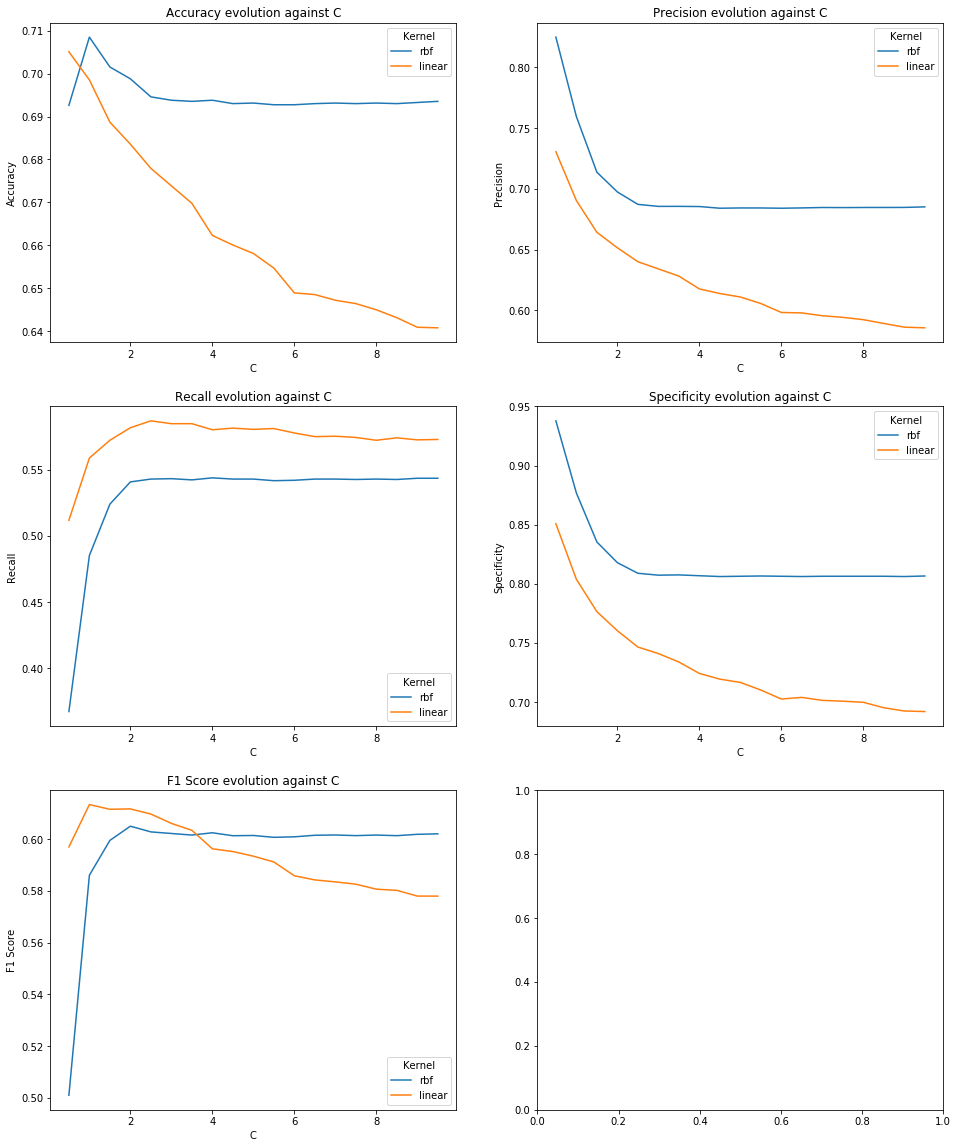

(<Figure size 1152x1440 with 6 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7effce75f048>,
       dtype=object))

In [70]:
plot_svm_summ_performance(svm_rbf_lin_perf)

In [71]:
svm_rbf_lin_perf

kernel    C                                      accuracy_fold  \
0      rbf  0.5  [0.7019041365725541, 0.6756401838476691, 0.674...   
1   linear  0.5  [0.711096520026264, 0.6677609980302035, 0.6730...   
2      rbf  1.0  [0.7150361129349967, 0.6743269862114248, 0.682...   
3   linear  1.0  [0.7196323046618516, 0.650032829940906, 0.6625...   
4      rbf  1.5  [0.7170059093893631, 0.6618516086671044, 0.671...   
5   linear  1.5  [0.7117531188443861, 0.6375574523965857, 0.654...   
6      rbf  2.0  [0.7183191070256073, 0.6611950098489823, 0.669...   
7   linear  2.0  [0.7117531188443861, 0.629021667760998, 0.6539...   
8      rbf  2.5  [0.7189757058437295, 0.6565988181221274, 0.665...   
9   linear  2.5  [0.706500328299409, 0.6217990807616546, 0.6487...   
10     rbf  3.0  [0.7189757058437295, 0.6552856204858831, 0.664...   
11  linear  3.0  [0.7032173342087984, 0.6139198949441891, 0.645...   
12     rbf  3.5  [0.7202889034799738, 0.6559422193040052, 0.664...   
13  linear  3.5  [0.7025607353906763, 0.6158896913985554, 0.635...   
14     rbf  4.0  [0.7202889034799738, 0.6579120157583717, 0.665...   
15  linear  4.0  [0.6953381483913329, 0.6126066973079448, 0.632...   
16     rbf  4.5  [0.7189757058437295, 0.6565988181221274, 0.664...   
17  linear  4.5  [0.6940249507550886, 0.6106369008535785, 0.627...   
18     rbf  5.0  [0.7189757058437295, 0.6572554169402495, 0.664...   
19  linear  5.0  [0.6920551543007223, 0.6040709126723572, 0.629...   
20     rbf  5.5  [0.7196323046618516, 0.6565988181221274, 0.664...   
21  linear  5.5  [0.6848325673013789, 0.6066973079448457, 0.623...   
22     rbf  6.0  [0.7196323046618516, 0.6552856204858831, 0.664...   
23  linear  6.0  [0.6808929743926461, 0.6021011162179908, 0.616...   
24     rbf  6.5  [0.7196323046618516, 0.6552856204858831, 0.664...   
25  linear  6.5  [0.6789231779382797, 0.6047275114904793, 0.619...   
26     rbf  7.0  [0.7196323046618516, 0.6552856204858831, 0.664...   
27  linear  7.0  [0.6762967826657912, 0.6047275114904793, 0.620...   
28     rbf  7.5  [0.7183191070256073, 0.6552856204858831, 0.664...   
29  linear  7.5  [0.6756401838476691, 0.6053841103086014, 0.619...   
30     rbf  8.0  [0.7183191070256073, 0.6552856204858831, 0.664...   
31  linear  8.0  [0.6723571897570584, 0.6080105055810899, 0.617...   
32     rbf  8.5  [0.7183191070256073, 0.654629021667761, 0.6638...   
33  linear  8.5  [0.6723571897570584, 0.6093237032173342, 0.615...   
34     rbf  9.0  [0.7183191070256073, 0.654629021667761, 0.6638...   
35  linear  9.0  [0.6690741956664478, 0.6040709126723572, 0.616...   
36     rbf  9.5  [0.7183191070256073, 0.6559422193040052, 0.663...   
37  linear  9.5  [0.6690741956664478, 0.6066973079448457, 0.619...   

                                       precision_fold  \
0   [0.8972332015810277, 0.745398773006135, 0.7239...   
1   [0.7897574123989218, 0.6456692913385826, 0.638...   
2   [0.8166189111747851, 0.6673728813559322, 0.665...   
3   [0.7638888888888888, 0.6023688663282571, 0.612...   
4   [0.7692307692307693, 0.6328871892925431, 0.633...   
5   [0.7327586206896551, 0.5817307692307693, 0.598...   
6   [0.7615740740740741, 0.6259124087591241, 0.623...   
7   [0.7213114754098361, 0.5700787401574803, 0.593...   
8   [0.7597254004576659, 0.6184448462929476, 0.619...   
9   [0.7055335968379447, 0.5609375, 0.585121602288...   
10  [0.7597254004576659, 0.6162162162162163, 0.617...   
11  [0.6978557504873294, 0.5512422360248447, 0.581...   
12  [0.7632183908045977, 0.6169064748201439, 0.617...   
13  [0.6942307692307692, 0.552833078101072, 0.5698...   
14  [0.7632183908045977, 0.6189624329159212, 0.617...   
15  [0.6791744840525328, 0.549079754601227, 0.5654...   
16  [0.7609195402298851, 0.618018018018018, 0.6166...   
17  [0.6753246753246753, 0.5469953775038521, 0.559...   
18  [0.7609195402298851, 0.6191335740072202, 0.616...   
19  [0.6709558823529411, 0.5390505359877489, 0.561...   
20  [0.7626728110599078, 0.618018018018018, 0.6166...   
21  [0.659380692167

Model with highest accuracy

In [72]:
svm_rbf_lin_perf.nlargest(3, 'accuracy_avg')[['C', 'kernel', 'accuracy_avg', 'precision_avg', 'recall_avg', 'specificity_avg', 'f1_score_avg']]

C  kernel  accuracy_avg  precision_avg  recall_avg  specificity_avg  \
2  1.0     rbf      0.708532       0.759444    0.485188         0.876816   
1  0.5  linear      0.705118       0.730526    0.511790         0.850793   
4  1.5     rbf      0.701570       0.713674    0.524010         0.835361   

   f1_score_avg  
2      0.586047  
1      0.596999  
4      0.599528

Model with highest f1 score

In [73]:
svm_rbf_lin_perf.nlargest(3, 'f1_score_avg')[['C', 'kernel', 'accuracy_avg', 'precision_avg', 'recall_avg', 'specificity_avg', 'f1_score_avg']]

C  kernel  accuracy_avg  precision_avg  recall_avg  specificity_avg  \
3  1.0  linear      0.698550       0.690352    0.558867         0.803813   
7  2.0  linear      0.683575       0.651491    0.581793         0.760284   
5  1.5  linear      0.688699       0.664254    0.572318         0.776405   

   f1_score_avg  
3      0.613387  
7      0.611713  
5      0.611557

Model performance gains seems to be not very significative. Model based in linear kernel and `C=1.0` outperforms all the f1 score metrics.

### XGBoost model

Try XGBoost models

In [90]:
params = {
        'max_depth': (2, 4, 6, 8),
        'eta': np.logspace(start=-5, stop=1, num=8),
        'num_round': np.around(np.logspace(start=2, stop=7, num=10, base=2)).astype('int32')
    }
params

{'max_depth': (2, 4, 6, 8),
 'eta': array([1.00000000e-05, 7.19685673e-05, 5.17947468e-04, 3.72759372e-03,
        2.68269580e-02, 1.93069773e-01, 1.38949549e+00, 1.00000000e+01]),
 'num_round': array([  4,   6,   9,  13,  19,  27,  40,  59,  87, 128], dtype=int32)}

In [91]:
xgb_perf2 = [] # To Save model performance statics

for p in ParameterGrid(params):
    np.random.seed(1)
    p.update({'objective': 'binary:logistic'})
    param = {
        'max_depth': p['max_depth'],
        'eta': p['eta'],
        'objective': p['objective'],
        'num_round': p['num_round'],
        'accuracy_fold': [],
        'precision_fold': [],
        'recall_fold': [],
        'specificity_fold': [],
        'f1_score_fold': []
    }
    
    print('Training with parameters: ', p)

    for train_index, test_index in kfold.split(X_train_vect2, y_train):
    
        # Split train and test partition
        X_train_part = X_train_vect2[train_index]
        y_train_part = y_train[train_index].values
        
        X_test_part = X_train_vect2[test_index]
        y_test_part = y_train[test_index].values
        
        # Fit XGBoost model
        xgb = XGBClassifier(**p)
        xgb.fit(X_train_part, y_train_part)
        
        # Predict over test
        y_pred = xgb.predict(X_test_part)
        
        # Meassure performance metrics
        param['accuracy_fold'].append(metrics.accuracy_score(y_test_part, y_pred))
        param['precision_fold'].append(metrics.precision_score(y_test_part, y_pred))
        param['recall_fold'].append(metrics.recall_score(y_test_part, y_pred))
        #  Exchange class 1 and 0 so measure recall for class 0 (specificity)
        param['specificity_fold'].append(metrics.recall_score(np.abs(y_test_part-1), np.abs(y_pred-1)))
        param['f1_score_fold'].append(metrics.f1_score(y_test_part, y_pred))
    
    # Compute global average metrics
    param['accuracy_avg'] = np.mean(param['accuracy_fold'])
    param['accuracy_std'] = np.std(param['accuracy_fold'])
    
    param['precision_avg'] = np.mean(param['precision_fold'])
    param['precision_std'] = np.std(param['precision_fold'])
    
    param['recall_avg'] = np.mean(param['recall_fold'])
    param['recall_std'] = np.std(param['recall_fold'])
    
    param['specificity_avg'] = np.mean(param['specificity_fold'])
    param['specificity_std'] = np.std(param['specificity_fold'])
    
    param['f1_score_avg'] = np.mean(param['f1_score_fold'])
    param['f1_score_std'] = np.std(param['f1_score_fold'])
    
    xgb_perf2.append(param)

xgb_perf2 = pd.DataFrame(xgb_perf2)

Training with parameters:  {'eta': 1e-05, 'max_depth': 2, 'num_round': 4, 'objective': 'binary:logistic'}
[23:16:16] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:16:16] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:16:17] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:16:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:16:17] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:16:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:16:19] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:16:19] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:16:19] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:16:19] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:16:21] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:16:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:16:21] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:16:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:16:23] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:16:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:16:23] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:16:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:16:25] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:16:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:16:25] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:16:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:16:27] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:16:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:16:27] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:16:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:16:29] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:16:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:16:29] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:16:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:16:31] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:16:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:16:32] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:16:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:16:33] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:16:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:16:34] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:16:34] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:16:35] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:16:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:16:36] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:16:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:16:38] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:16:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:16:38] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:16:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:16:41] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:16:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:16:41] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:16:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:16:44] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:16:44] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:16:44] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:16:44] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:16:47] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:16:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:16:47] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:16:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:16:50] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:16:50] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:16:50] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:16:50] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:16:52] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:16:52] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:16:53] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:16:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:16:55] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:16:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:16:56] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:16:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:16:58] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:16:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:16:59] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:16:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:17:03] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:17:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:17:03] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:17:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:17:05] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:17:05] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:17:06] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:17:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:17:08] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:17:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:17:09] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:17:09] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:17:12] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:17:12] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:17:13] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:17:13] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:17:16] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:17:16] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:17:17] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:17:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:17:20] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:17:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:17:20] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:17:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:17:23] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:17:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:17:24] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:17:24] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:17:27] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:17:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:17:28] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:17:28] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:17:31] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:17:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:17:32] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:17:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:17:35] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:17:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:17:35] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:17:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:17:38] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:17:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:17:39] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:17:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:17:42] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:17:42] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:17:43] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:17:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:17:46] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:17:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:17:47] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:17:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:17:50] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:17:50] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:17:51] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:17:51] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:17:55] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:17:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:17:56] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:17:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:17:59] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:17:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:18:00] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:18:00] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:18:04] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:18:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:18:05] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:18:05] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:18:10] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:18:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:18:10] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:18:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:18:14] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:18:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:18:15] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:18:15] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:18:19] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:18:19] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:18:20] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:18:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:18:24] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:18:24] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:18:25] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:18:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:18:29] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:18:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:18:29] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:18:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:18:33] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:18:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:18:33] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:18:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:18:35] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:18:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:18:35] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:18:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:18:36] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:18:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:18:37] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:18:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:18:38] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:18:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:18:39] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:18:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:18:40] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:18:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:18:41] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:18:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:18:42] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:18:42] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:18:43] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:18:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:18:44] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:18:44] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:18:45] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:18:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:18:46] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:18:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:18:46] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:18:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:18:48] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:18:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:18:48] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:18:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:18:50] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:18:50] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:18:50] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:18:50] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:18:52] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:18:52] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:18:53] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:18:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:18:55] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:18:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:18:55] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:18:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:18:58] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:18:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:18:58] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:18:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:19:01] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:19:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:19:01] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:19:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:19:04] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:19:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:19:04] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:19:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:19:07] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:19:07] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:19:07] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:19:07] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:19:10] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:19:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:19:10] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:19:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:19:13] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:19:13] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:19:13] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:19:13] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:19:16] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:19:16] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:19:16] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:19:16] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:19:19] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:19:19] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:19:19] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:19:19] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:19:21] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:19:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:19:22] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:19:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:19:25] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:19:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:19:26] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:19:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:19:29] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:19:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:19:30] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:19:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:19:33] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:19:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:19:34] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:19:34] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:19:37] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:19:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:19:38] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:19:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:19:41] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:19:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:19:41] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:19:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:19:44] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:19:44] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:19:45] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:19:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:19:48] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:19:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:19:49] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:19:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:19:51] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:19:51] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:19:52] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:19:52] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:19:55] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:19:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:19:56] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:19:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:19:59] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:19:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:20:00] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:20:00] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:20:03] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:20:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:20:04] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:20:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:20:08] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:20:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:20:10] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:20:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:20:14] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:20:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:20:14] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:20:15] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:20:18] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:20:18] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:20:19] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:20:19] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:20:23] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:20:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:20:24] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:20:24] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:20:27] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:20:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:20:28] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:20:28] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:20:32] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:20:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:20:33] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:20:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:20:36] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:20:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:20:37] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:20:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:20:41] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:20:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:20:42] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:20:42] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:20:45] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:20:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:20:45] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:20:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:20:47] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:20:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:20:47] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:20:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:20:49] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:20:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:20:49] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:20:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:20:50] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:20:50] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:20:51] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:20:51] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:20:52] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:20:52] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:20:53] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:20:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:20:54] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:20:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:20:55] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:20:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:20:56] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:20:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:20:57] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:20:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:20:58] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:20:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:20:59] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:20:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:21:01] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:21:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:21:02] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:21:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:21:09] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:21:09] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:21:09] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:21:09] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:21:11] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:21:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:21:11] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:21:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:21:15] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:21:15] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:21:16] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:21:16] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:21:19] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:21:19] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:21:20] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:21:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:21:22] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:21:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:21:23] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:21:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:21:26] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:21:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:21:27] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:21:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:21:29] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:21:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:21:30] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:21:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:21:32] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:21:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:21:33] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:21:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:21:36] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:21:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:21:36] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:21:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:21:38] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:21:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:21:39] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:21:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:21:41] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:21:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:21:42] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:21:42] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:21:44] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:21:44] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:21:45] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:21:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:21:48] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:21:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:21:48] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:21:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:21:51] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:21:51] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:21:52] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:21:52] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:21:55] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:21:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:21:56] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:21:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:21:59] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:21:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:21:59] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:21:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:22:02] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:22:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:22:03] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:22:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:22:06] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:22:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:22:07] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:22:07] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:22:10] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:22:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:22:11] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:22:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:22:14] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:22:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:22:15] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:22:15] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:22:18] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:22:18] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:22:19] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:22:19] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:22:22] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:22:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:22:23] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:22:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:22:26] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:22:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:22:27] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:22:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:22:31] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:22:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:22:32] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:22:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:22:35] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:22:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:22:36] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:22:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:22:40] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:22:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:22:40] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:22:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:22:44] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:22:44] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:22:45] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:22:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:22:48] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:22:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:22:49] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:22:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:22:53] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:22:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:22:54] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:22:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:22:57] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:22:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:22:58] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:22:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:23:02] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:23:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:23:03] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:23:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:23:06] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:23:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:23:06] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:23:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:23:08] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:23:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:23:08] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:23:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:23:10] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:23:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:23:10] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:23:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:23:11] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:23:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:23:12] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:23:12] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:23:13] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:23:13] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:23:14] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:23:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:23:15] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:23:15] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:23:16] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:23:16] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:23:17] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:23:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:23:18] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:23:18] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:23:19] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:23:19] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:23:20] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:23:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:23:21] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:23:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:23:21] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:23:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:23:23] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:23:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:23:23] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:23:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:23:25] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:23:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:23:26] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:23:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:23:28] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:23:28] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:23:28] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:23:28] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:23:31] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:23:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:23:31] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:23:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:23:33] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:23:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:23:34] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:23:34] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:23:36] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:23:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:23:37] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:23:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:23:39] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:23:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:23:39] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:23:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:23:42] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:23:42] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:23:42] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:23:42] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:23:44] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:23:44] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:23:45] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:23:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:23:47] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:23:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:23:48] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:23:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:23:50] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:23:50] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:23:50] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:23:50] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:23:53] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:23:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:23:53] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:23:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:23:56] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:23:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:23:57] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:23:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:24:00] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:24:00] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:24:01] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:24:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:24:04] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:24:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:24:04] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:24:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:24:07] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:24:07] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:24:08] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:24:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:24:12] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:24:12] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:24:13] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:24:13] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:24:15] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:24:15] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:24:16] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:24:16] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:24:19] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:24:19] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:24:20] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:24:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:24:23] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:24:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:24:23] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:24:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:24:26] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:24:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:24:27] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:24:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:24:30] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:24:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:24:31] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:24:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:24:35] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:24:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:24:36] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:24:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:24:39] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:24:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:24:40] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:24:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:24:44] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:24:44] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:24:45] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:24:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:24:48] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:24:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:24:49] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:24:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:24:53] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:24:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:24:54] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:24:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:24:57] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:24:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:24:58] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:24:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:25:02] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:25:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:25:03] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:25:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:25:06] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:25:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:25:07] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:25:07] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:25:11] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:25:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:25:12] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:25:12] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:25:15] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:25:15] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:25:15] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:25:15] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:25:17] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:25:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:25:17] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:25:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:25:19] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:25:19] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:25:19] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:25:19] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:25:21] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:25:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:25:21] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:25:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:25:23] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:25:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:25:23] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:25:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:25:24] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:25:24] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:25:25] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:25:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:25:26] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:25:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:25:27] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:25:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:25:28] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:25:28] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:25:29] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:25:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:25:30] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:25:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:25:31] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:25:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:25:32] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:25:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:25:33] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:25:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:25:34] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:25:34] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:25:35] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:25:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:25:37] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:25:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:25:38] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:25:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:25:40] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:25:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:25:40] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:25:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:25:43] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:25:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:25:43] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:25:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:25:45] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:25:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:25:46] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:25:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:25:48] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:25:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:25:49] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:25:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:25:51] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:25:51] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:25:51] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:25:51] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:25:53] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:25:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:25:54] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:25:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:25:56] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:25:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:25:57] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:25:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:25:59] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:25:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:26:00] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:26:00] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:26:02] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:26:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:26:03] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:26:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:26:06] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:26:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:26:07] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:26:07] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:26:11] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:26:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:26:11] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:26:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:26:14] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:26:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:26:15] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:26:15] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:26:18] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:26:18] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:26:18] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:26:18] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:26:21] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:26:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:26:22] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:26:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:26:25] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:26:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:26:26] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:26:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:26:28] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:26:28] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:26:29] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:26:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:26:32] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:26:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:26:33] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:26:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:26:36] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:26:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:26:36] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:26:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:26:39] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:26:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:26:40] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:26:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:26:44] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:26:44] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:26:45] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:26:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:26:48] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:26:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:26:49] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:26:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:26:53] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:26:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:26:54] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:26:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:26:57] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:26:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:26:58] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:26:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:27:02] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:27:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:27:03] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:27:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:27:06] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:27:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:27:07] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:27:07] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:27:11] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:27:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:27:11] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:27:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:27:15] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:27:15] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:27:16] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:27:16] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:27:19] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:27:19] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:27:20] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:27:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:27:23] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:27:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:27:24] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:27:24] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:27:25] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:27:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:27:26] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:27:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:27:27] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:27:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:27:27] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:27:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:27:29] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:27:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:27:29] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:27:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:27:31] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:27:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:27:31] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:27:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:27:33] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:27:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:27:33] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:27:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:27:35] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:27:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:27:35] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:27:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:27:37] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:27:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:27:37] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:27:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:27:39] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:27:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:27:39] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:27:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:27:41] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:27:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:27:41] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:27:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:27:43] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:27:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:27:43] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:27:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:27:45] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:27:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:27:46] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:27:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:27:48] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:27:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:27:49] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:27:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:27:51] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:27:51] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:27:51] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:27:51] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:27:54] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:27:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:27:54] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:27:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:27:56] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:27:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:27:57] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:27:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:27:59] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:27:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:27:59] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:27:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:28:02] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:28:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:28:03] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:28:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:28:05] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:28:05] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:28:06] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:28:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:28:08] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:28:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:28:09] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:28:09] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:28:12] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:28:12] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:28:13] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:28:13] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:28:15] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:28:15] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:28:16] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:28:16] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:28:19] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:28:19] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:28:20] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:28:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:28:22] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:28:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:28:23] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:28:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:28:26] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:28:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:28:27] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:28:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:28:29] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:28:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:28:30] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:28:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:28:33] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:28:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:28:34] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:28:34] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:28:37] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:28:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:28:37] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:28:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:28:40] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:28:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:28:41] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:28:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:28:44] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:28:44] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:28:44] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:28:44] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:28:47] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:28:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:28:48] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:28:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:28:52] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:28:52] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:28:53] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:28:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:28:56] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:28:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:28:57] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:28:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:29:00] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:00] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:29:01] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:29:05] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:05] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:29:05] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:05] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:29:09] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:09] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:29:10] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:29:13] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:13] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:29:14] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:29:17] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:29:18] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:18] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:29:22] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:29:23] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:29:26] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:29:27] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:29:30] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:29:30] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:29:32] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:29:32] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:29:33] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:29:34] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:34] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:29:35] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:29:36] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:29:37] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:29:38] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:29:39] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:29:39] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:29:41] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:29:41] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:29:43] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:29:43] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:29:45] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:29:45] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:29:47] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:29:47] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:29:49] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:29:49] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:29:51] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:51] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:29:52] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:52] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:29:54] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:29:54] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:29:56] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:29:57] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:29:59] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:29:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:30:00] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:00] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:30:02] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:30:02] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:30:04] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:30:05] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:05] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:30:07] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:07] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:30:07] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:07] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:30:10] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:30:11] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:30:13] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:13] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:30:14] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:30:16] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:16] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:30:17] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:30:19] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:19] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:30:20] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:30:23] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:30:23] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:30:26] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:30:27] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:30:29] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:30:30] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:30:32] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:30:33] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:30:36] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:30:36] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:30:39] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:30:40] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:30:42] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:42] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:30:43] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:30:46] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:30:46] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:30:49] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:30:50] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:50] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:30:53] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:30:54] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:30:57] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:30:58] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:30:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:31:01] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:31:02] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:31:05] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:05] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:31:06] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:31:09] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:09] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:31:10] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:31:13] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:13] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:31:14] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:31:17] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:31:18] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:18] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:31:21] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:31:22] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:31:25] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:31:26] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:31:29] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:31:29] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:31:30] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:31:30] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:31:31] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:31:31] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:31:32] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:31:33] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:31:34] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:34] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:31:34] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:34] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:31:35] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:31:35] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:31:36] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:31:36] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:31:37] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:31:38] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:31:39] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:31:39] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:31:40] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:31:40] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:31:41] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:31:41] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[23:31:42] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:42] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:31:42] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:42] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:31:42] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:31:43] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[23:31:43] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:31:43] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:31:44] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:44] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:31:44] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:44] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[23:31:44] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:44] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:31:45] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:31:45] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:31:45] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[23:31:46] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:31:46] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:31:46] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:31:47] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[23:31:47] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:31:47] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:31:48] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:31:48] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[23:31:48] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:31:48] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:31:49] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:31:49] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[23:31:49] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:31:50] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:50] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:31:50] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:50] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:31:50] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:50] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[23:31:51] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:51] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:31:51] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:51] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:31:51] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:51] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:31:52] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:52] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[23:31:52] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:52] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:31:52] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:52] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:31:53] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:31:53] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[23:31:53] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:31:54] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:31:54] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:31:54] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:31:55] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:31:56] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:31:57] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:31:57] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:31:58] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:31:58] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:31:59] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:31:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:32:00] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:32:00] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:32:01] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:32:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:32:01] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:32:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:32:02] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:32:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:32:02] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:32:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:32:03] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:32:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:32:03] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:32:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:32:04] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:32:05] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:32:05] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:32:05] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:32:06] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:32:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:32:06] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:32:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:32:07] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:32:07] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:32:07] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:32:07] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eva

/home/nico/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Training with parameters:  {'eta': 10.0, 'max_depth': 8, 'num_round': 6, 'objective': 'binary:logistic'}
[23:32:08] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:32:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:32:08] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you f

/home/nico/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Training with parameters:  {'eta': 10.0, 'max_depth': 8, 'num_round': 9, 'objective': 'binary:logistic'}
[23:32:11] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:32:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:32:11] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you f

/home/nico/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Training with parameters:  {'eta': 10.0, 'max_depth': 8, 'num_round': 13, 'objective': 'binary:logistic'}
[23:32:12] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:32:12] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:32:12] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you 

/home/nico/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Training with parameters:  {'eta': 10.0, 'max_depth': 8, 'num_round': 19, 'objective': 'binary:logistic'}
[23:32:13] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:32:13] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:32:13] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you 

/home/nico/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Training with parameters:  {'eta': 10.0, 'max_depth': 8, 'num_round': 27, 'objective': 'binary:logistic'}
[23:32:15] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:32:15] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:32:15] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you 

/home/nico/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Training with parameters:  {'eta': 10.0, 'max_depth': 8, 'num_round': 40, 'objective': 'binary:logistic'}
[23:32:16] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:32:16] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:32:16] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you 

/home/nico/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Training with parameters:  {'eta': 10.0, 'max_depth': 8, 'num_round': 59, 'objective': 'binary:logistic'}
[23:32:17] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:32:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:32:17] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you 

/home/nico/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Training with parameters:  {'eta': 10.0, 'max_depth': 8, 'num_round': 87, 'objective': 'binary:logistic'}
[23:32:18] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:32:18] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:32:19] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you 

/home/nico/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nico/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Training with parameters:  {'eta': 10.0, 'max_depth': 8, 'num_round': 128, 'objective': 'binary:logistic'}
[23:32:20] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:32:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:32:20] WARNING: ../src/learner.cc:573: 
Parameters: { "num_round" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you

/home/nico/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [92]:
xgb_perf2

max_depth       eta        objective  num_round  \
0            2   0.00001  binary:logistic          4   
1            2   0.00001  binary:logistic          6   
2            2   0.00001  binary:logistic          9   
3            2   0.00001  binary:logistic         13   
4            2   0.00001  binary:logistic         19   
..         ...       ...              ...        ...   
315          8  10.00000  binary:logistic         27   
316          8  10.00000  binary:logistic         40   
317          8  10.00000  binary:logistic         59   
318          8  10.00000  binary:logistic         87   
319          8  10.00000  binary:logistic        128   

                                         accuracy_fold  \
0    [0.5975049244911359, 0.6165462902166776, 0.641...   
1    [0.5975049244911359, 0.6165462902166776, 0.641...   
2    [0.5975049244911359, 0.6165462902166776, 0.641...   
3    [0.5975049244911359, 0.6165462902166776, 0.641...   
4    [0.5975049244911359, 0.6165462902166776, 0.641...   
..                                                 ...   
315  [0.6480630334865397, 0.618516086671044, 0.6421...   
316  [0.6480630334865397, 0.618516086671044, 0.6421...   
317  [0.6480630334865397, 0.618516086671044, 0.6421...   
318  [0.6480630334865397, 0.618516086671044, 0.6421...   
319  [0.6480630334865397, 0.618516086671044, 0.6421...   

                                        precision_fold  \
0    [0.5282258064516129, 0.5589225589225589, 0.578...   
1    [0.5282258064516129, 0.5589225589225589, 0.578...   
2    [0.5282258064516129, 0.5589225589225589, 0.578...   
3    [0.5282258064516129, 0.5589225589225589, 0.578...   
4    [0.5282258064516129, 0.5589225589225589, 0.578...   
..                                                 ...   
315  [0.6142034548944337, 0.5630397236614854, 0.580...   
316  [0.6142034548944337, 0.5630397236614854, 0.580...   
317  [0.6142034548944337, 0.5630397236614854, 0.580...   
318  [0.6142034548944337, 0.5630397236614854, 0.580...   
319  [0.6142034548944337, 0.5630397236614854, 0.580...   

                                           recall_fold  \
0    [0.6, 0.5076452599388379, 0.6085626911314985, ...   
1    [0.6, 0.5076452599388379, 0.6085626911314985, ...   
2    [0.6, 0.5076452599388379, 0.6085626911314985, ...   
3    [0.6, 0.5076452599388379, 0.6085626911314985, ...   
4    [0.6, 0.5076452599388379, 0.6085626911314985, ...   
..                                                 ...   
315  [0.48854961832061067, 0.4984709480122324, 0.59...   
316  [0.48854961832061067, 0.4984709480122324, 0.59...   
317  [0.48854961832061067, 0.4984709480122324, 0.59...   
318  [0.48854961832061067, 0.4984709480122324, 0.59...   
319  [0.48854961832061067, 0.4984709480122324, 0.59...   

                                      specificity_fold  \
0    [0.5956221198156681, 0.6985040276179517, 0.666...   
1    [0.5956221198156681, 0.6985040276179517, 0.666...   
2    [0.5956221198156681, 0.6985040276179517, 0.666...   
3    [0.5956221198156681, 0.6985040276179517, 0.666...   
4    [0.5956221198156681, 0.6985040276179517, 0.666...   
..                                                 ...   
315  [0.7684331797235023, 0.7088607594936709, 0.675...   
316  [0.7684331797235023, 0.7088607594936709, 0.675...   
317  [0.7684331797235023, 0.7088607594936709, 0.675...   
318  [0.7684331797235023, 0.7088607594936709, 0.675...   
319  [0.7684331797235023, 0.7088607594936709, 0.675...   

                                         f1_score_fold  accuracy_avg  \
0    [0.5618298784846318, 0.5320512820512819, 0.593...      0.637075   
1    [0.5618298784846318, 0.5320512820512819, 0.593...      0.637075   
2    [0.5618298784846318, 0.5320512820512819, 0.593...      0.637075   
3    [0.5618298784846318, 0.5320512820512819, 0.593...      0.637075   
4    [0.5618298784846318, 0.5320512820512819, 0.593...      0.637075   
..                                                 ...           ...   
315  [0.5442176870748299, 0.528791565287

Models with highest accuracy and f1-score

In [93]:
xgb_perf.nlargest(3, 'accuracy_avg')[['eta', 'num_round',
                                              'max_depth',
                                          'accuracy_avg',
                                          'precision_avg',
                                          'recall_avg',
                                          'specificity_avg',
                                          'f1_score_avg']]

eta  num_round  max_depth  accuracy_avg  precision_avg  recall_avg  \
190  0.026827          4          8      0.667157       0.664103    0.459806   
191  0.026827          6          8      0.667157       0.664103    0.459806   
192  0.026827          9          8      0.667157       0.664103    0.459806   

     specificity_avg  f1_score_avg  
190          0.82338      0.541609  
191          0.82338      0.541609  
192          0.82338      0.541609

In [94]:
xgb_perf.nlargest(3, 'f1_score_avg')[['eta', 'num_round',
                                              'max_depth',
                                          'accuracy_avg',
                                          'precision_avg',
                                          'recall_avg',
                                          'specificity_avg',
                                          'f1_score_avg']]

eta  num_round  max_depth  accuracy_avg  precision_avg  recall_avg  \
260  1.389495          4          6      0.651134       0.616543      0.5234   
261  1.389495          6          6      0.651134       0.616543      0.5234   
262  1.389495          9          6      0.651134       0.616543      0.5234   

     specificity_avg  f1_score_avg  
260         0.747392      0.562553  
261         0.747392      0.562553  
262         0.747392      0.562553

## Training without non-alfanumeric a words

Try if removing non-alfanumeric words (web urls, numbers, emojis) from records codifications leads to a performance gain.

In [101]:
# Retrieve the list of words only appearing 1 time
less_freq_words = set(train_word_freq[train_word_freq == 1].index)

# Remove less frequent words
remove_less_frequent = lambda x: [word for word in x if word not in less_freq_words]
X_train_red3 = X_train.apply(remove_less_frequent)
X_test_red3 = X_test.apply(remove_less_frequent)

# Remove tokens from non-alfanumeric words
tokens = {'tweburlt', 'tyeart', 'thourt', 'tnumbert', 'temojit'}
remove_tokens = lambda x: [word for word in x if word not in tokens]
X_train_red3 = X_train_red3.apply(remove_tokens)
X_test_red3 = X_test_red3.apply(remove_tokens)

# Turn arrays into text
X_train_red3 = X_train_red3.apply(lambda x: ' '.join(x))
X_test_red3 = X_test_red3.apply(lambda x: ' '.join(x))

# Vectorize
vectorizer = TfidfVectorizer()
X_train_vect3 = vectorizer.fit_transform(X_train_red3)
X_test_vect3 = vectorizer.transform(X_test_red3)

In [102]:
print('Number of columns: ', X_train_vect3.shape[1])

Number of columns:  5279


Repeat experiments with SVM models with *rbf* and *linear* kernels

In [103]:
# Experiment parameters
params = {
        'kernel': ('rbf', 'linear'),
        'C': np.arange(0.5, 10, 0.5)
    }

# Prepare kfold
K = 5
kfold = StratifiedKFold(n_splits=K)
svm_rbf_lin_perf2 = [] # To Save model performance statics

# Perform experiments
for p in ParameterGrid(params):
    np.random.seed(1)
    param = {
        'kernel': p['kernel'],
        'C': p['C'],
        'accuracy_fold': [],
        'precision_fold': [],
        'recall_fold': [],
        'specificity_fold': [],
        'f1_score_fold': []
    }
    
    print('Training with parameters: ', p)

    for train_index, test_index in kfold.split(X_train_vect3, y_train):

        # Split train and test partition
        X_train_part = X_train_vect3[train_index]
        y_train_part = y_train[train_index].values

        X_test_part = X_train_vect3[test_index]
        y_test_part = y_train[test_index].values

        # Fit SVM model
        svm = SVC(kernel=p['kernel'], C=p['C'])
        svm.fit(X_train_part, y_train_part)

        # Predict over test
        y_pred = svm.predict(X_test_part)

        # Meassure performance metrics
        param['accuracy_fold'].append(metrics.accuracy_score(y_test_part, y_pred))
        param['precision_fold'].append(metrics.precision_score(y_test_part, y_pred))
        param['recall_fold'].append(metrics.recall_score(y_test_part, y_pred))
        #  Exchange class 1 and 0 so measure recall for class 0 (specificity)
        param['specificity_fold'].append(metrics.recall_score(np.abs(y_test_part-1), np.abs(y_pred-1)))
        param['f1_score_fold'].append(metrics.f1_score(y_test_part, y_pred))

    # Compute global average metrics
    param['accuracy_avg'] = np.mean(param['accuracy_fold'])
    param['accuracy_std'] = np.std(param['accuracy_fold'])

    param['precision_avg'] = np.mean(param['precision_fold'])
    param['precision_std'] = np.std(param['precision_fold'])

    param['recall_avg'] = np.mean(param['recall_fold'])
    param['recall_std'] = np.std(param['recall_fold'])

    param['specificity_avg'] = np.mean(param['specificity_fold'])
    param['specificity_std'] = np.std(param['specificity_fold'])

    param['f1_score_avg'] = np.mean(param['f1_score_fold'])
    param['f1_score_std'] = np.std(param['f1_score_fold'])

    svm_rbf_lin_perf2.append(param)

svm_rbf_lin_perf2 = pd.DataFrame(svm_rbf_lin_perf2)

Training with parameters:  {'C': 0.5, 'kernel': 'rbf'}
Training with parameters:  {'C': 0.5, 'kernel': 'linear'}
Training with parameters:  {'C': 1.0, 'kernel': 'rbf'}
Training with parameters:  {'C': 1.0, 'kernel': 'linear'}
Training with parameters:  {'C': 1.5, 'kernel': 'rbf'}
Training with parameters:  {'C': 1.5, 'kernel': 'linear'}
Training with parameters:  {'C': 2.0, 'kernel': 'rbf'}
Training with parameters:  {'C': 2.0, 'kernel': 'linear'}
Training with parameters:  {'C': 2.5, 'kernel': 'rbf'}
Training with parameters:  {'C': 2.5, 'kernel': 'linear'}
Training with parameters:  {'C': 3.0, 'kernel': 'rbf'}
Training with parameters:  {'C': 3.0, 'kernel': 'linear'}
Training with parameters:  {'C': 3.5, 'kernel': 'rbf'}
Training with parameters:  {'C': 3.5, 'kernel': 'linear'}
Training with parameters:  {'C': 4.0, 'kernel': 'rbf'}
Training with parameters:  {'C': 4.0, 'kernel': 'linear'}
Training with parameters:  {'C': 4.5, 'kernel': 'rbf'}
Training with parameters:  {'C': 4.5, 'ke

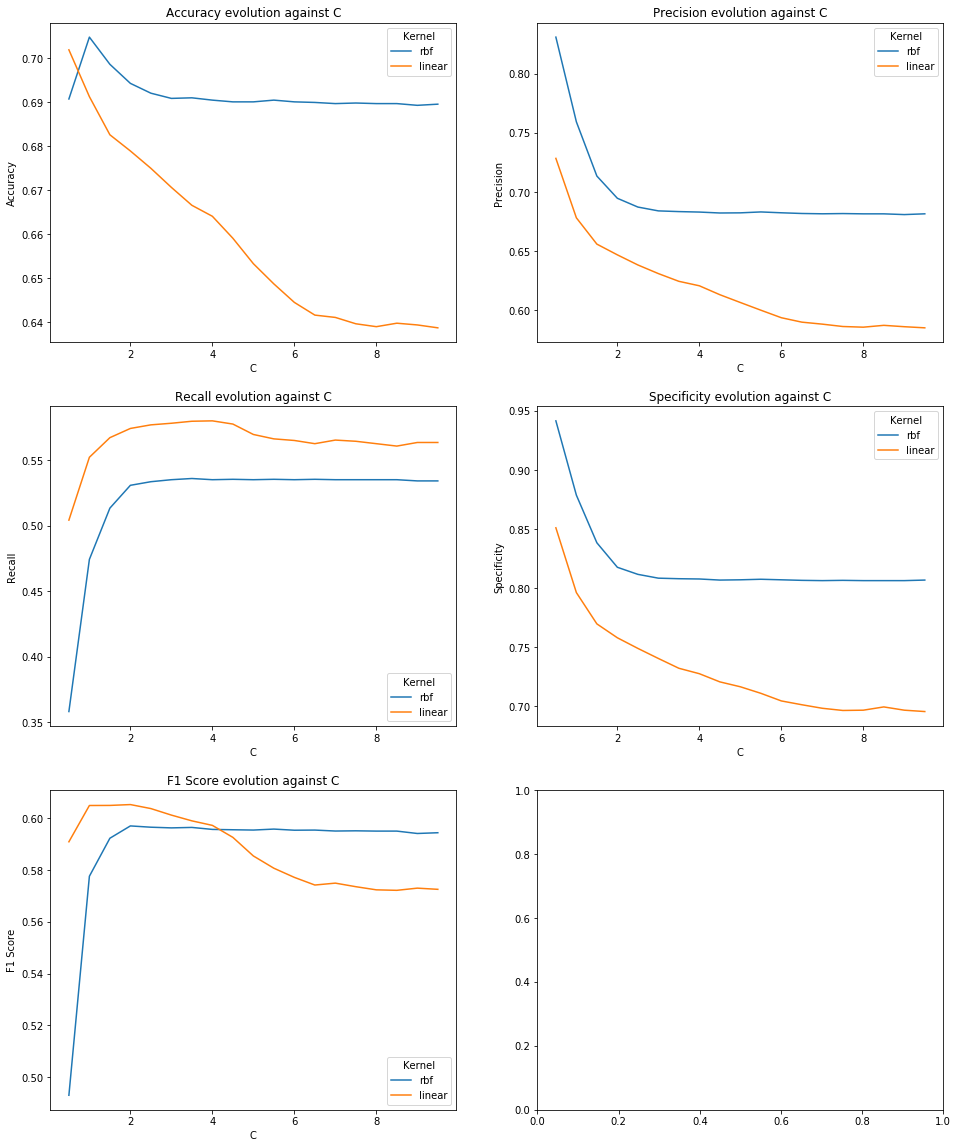

(<Figure size 1152x1440 with 6 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f88308421d0>,
       dtype=object))

In [104]:
plot_svm_summ_performance(svm_rbf_lin_perf2)

In [105]:
svm_rbf_lin_perf2

kernel    C                                      accuracy_fold  \
0      rbf  0.5  [0.7084701247537755, 0.6605384110308602, 0.669...   
1   linear  0.5  [0.7150361129349967, 0.6618516086671044, 0.667...   
2      rbf  1.0  [0.726854891661195, 0.6644780039395929, 0.6743...   
3   linear  1.0  [0.7196323046618516, 0.6428102429415627, 0.650...   
4      rbf  1.5  [0.7288246881155613, 0.659881812212738, 0.6664...   
5   linear  1.5  [0.7117531188443861, 0.6303348653972423, 0.634...   
6      rbf  2.0  [0.7242284963887065, 0.6559422193040052, 0.656...   
7   linear  2.0  [0.7038739330269206, 0.6257386736703874, 0.638...   
8      rbf  2.5  [0.7222586999343401, 0.6533158240315168, 0.653...   
9   linear  2.5  [0.7084701247537755, 0.6165462902166776, 0.640...   
10     rbf  3.0  [0.7209455022980958, 0.6520026263952725, 0.654...   
11  linear  3.0  [0.7045305318450427, 0.6172028890347997, 0.636...   
12     rbf  3.5  [0.7189757058437295, 0.6533158240315168, 0.656...   
13  linear  3.5  [0.7038739330269206, 0.6165462902166776, 0.629...   
14     rbf  4.0  [0.7196323046618516, 0.6526592252133946, 0.655...   
15  linear  4.0  [0.7045305318450427, 0.618516086671044, 0.6231...   
16     rbf  4.5  [0.7189757058437295, 0.6533158240315168, 0.655...   
17  linear  4.5  [0.7005909389363099, 0.6126066973079448, 0.623...   
18     rbf  5.0  [0.7189757058437295, 0.6539724228496389, 0.655...   
19  linear  5.0  [0.6933683519369666, 0.6165462902166776, 0.616...   
20     rbf  5.5  [0.7189757058437295, 0.6533158240315168, 0.657...   
21  linear  5.5  [0.6874589625738674, 0.6066973079448457, 0.616...   
22     rbf  6.0  [0.7189757058437295, 0.6520026263952725, 0.657...   
23  linear  6.0  [0.6828627708470125, 0.6053841103086014, 0.616...   
24     rbf  6.5  [0.7196323046618516, 0.6520026263952725, 0.657...   
25  linear  6.5  [0.6795797767564018, 0.603414313854235, 0.6126...   
26     rbf  7.0  [0.7183191070256073, 0.6533158240315168, 0.655...   
27  linear  7.0  [0.6795797767564018, 0.6073539067629679, 0.613...   
28     rbf  7.5  [0.7176625082074852, 0.6533158240315168, 0.656...   
29  linear  7.5  [0.6776099803020355, 0.6106369008535785, 0.612...   
30     rbf  8.0  [0.7176625082074852, 0.6533158240315168, 0.656...   
31  linear  8.0  [0.6782665791201575, 0.6099803020354564, 0.609...   
32     rbf  8.5  [0.7176625082074852, 0.6533158240315168, 0.656...   
33  linear  8.5  [0.6795797767564018, 0.6066973079448457, 0.611...   
34     rbf  9.0  [0.7170059093893631, 0.6539724228496389, 0.656...   
35  linear  9.0  [0.6769533814839134, 0.6066973079448457, 0.612...   
36     rbf  9.5  [0.7176625082074852, 0.6539724228496389, 0.656...   
37  linear  9.5  [0.6776099803020355, 0.6099803020354564, 0.610...   

                                       precision_fold  \
0   [0.9137254901960784, 0.7231270358306189, 0.722...   
1   [0.8095238095238095, 0.6339113680154143, 0.635...   
2   [0.8567164179104477, 0.6518046709129511, 0.661...   
3   [0.7638888888888888, 0.5929054054054054, 0.599...   
4   [0.8118556701030928, 0.6287878787878788, 0.632...   
5   [0.7307692307692307, 0.5737439222042139, 0.575...   
6   [0.784503631961259, 0.6181818181818182, 0.6104...   
7   [0.7090163934426229, 0.5668789808917197, 0.576...   
8   [0.7735849056603774, 0.6137184115523465, 0.607...   
9   [0.709741550695825, 0.555205047318612, 0.57949...   
10  [0.7699530516431925, 0.6115107913669064, 0.607...   
11  [0.700587084148728, 0.5555555555555556, 0.5730...   
12  [0.7645687645687645, 0.6137184115523465, 0.610...   
13  [0.6954022988505747, 0.5545171339563862, 0.563...   
14  [0.7663551401869159, 0.6126126126126126, 0.609...   
15  [0.6944971537001897, 0.5569422776911076, 0.556...   
16  [0.7645687645687645, 0.6133093525179856, 0.608...   
17  [0.685981308411215, 0.5495356037151703, 0.5557...   
18  [0.7645687645687645, 0.6144144144144145, 0.608...   
19  [0.6734317343173432, 0.5540123456790124, 0.548...   
20  [0.7645687645687645, 0.6141304347826086, 0.609...   
21  [0.663619744058

In [106]:
svm_rbf_lin_perf2.to_csv('SVM_kernel-rbf-linear_exp.csv', sep=';')

Models with highest accuracy and f1-score

In [107]:
svm_rbf_lin_perf2.nlargest(3, 'accuracy_avg')[['C', 'kernel',
                                              'accuracy_avg',
                                              'precision_avg',
                                              'recall_avg',
                                              'specificity_avg',
                                              'f1_score_avg']]

C  kernel  accuracy_avg  precision_avg  recall_avg  specificity_avg  \
2  1.0     rbf      0.704853       0.759362    0.474178         0.878659   
1  0.5  linear      0.701965       0.728414    0.504146         0.851025   
4  1.5     rbf      0.698679       0.713434    0.513309         0.838354   

   f1_score_avg  
2      0.577608  
1      0.590909  
4      0.592280

In [108]:
svm_rbf_lin_perf2.nlargest(3, 'f1_score_avg')[['C', 'kernel',
                                              'accuracy_avg',
                                              'precision_avg',
                                              'recall_avg',
                                              'specificity_avg',
                                              'f1_score_avg']]

C  kernel  accuracy_avg  precision_avg  recall_avg  specificity_avg  \
7  2.0  linear      0.678979       0.646694    0.574150         0.757982   
5  1.5  linear      0.682657       0.655786    0.567119         0.769728   
3  1.0  linear      0.691326       0.678071    0.552140         0.796211   

   f1_score_avg  
7      0.605273  
5      0.604944  
3      0.604915

SVM model with `C=1.0` and *linear* kernel outperforms the f1-score metrics. Despite, on comparing this performance against the models obtained in the previous set of experiments, it is checked that non-significative gain on performance has been achieved through this ammend.

Let's try to repeat the experiments by using all the words

In [49]:
# Turn arrays into text
X_train = X_train.apply(lambda x: ' '.join(x))
X_test = X_test.apply(lambda x: ' '.join(x))

# Vectorize
vectorizer = TfidfVectorizer()
X_train_vect3 = vectorizer.fit_transform(X_train)
X_test_vect3 = vectorizer.transform(X_test)

In [50]:
print('Number of columns: {}'.format(X_train_vect3.shape[1]))

Number of columns: 13823


Repeat experiments by using the following parameters:

In [51]:
# Experiment parameters
kernels = ('rbf', 'linear')
C_values = np.arange(0.5, 5, 0.5)

# Prepare kfold
K = 5
kfold = StratifiedKFold(n_splits=K)

In [52]:
svm_rbf_lin_perf3 = [] # To Save model performance statics

for kernel in kernels:
    for C in C_values:
        np.random.seed(1)
        param = {
            'kernel': kernel,
            'C': C,
            'accuracy_fold': [],
            'precision_fold': [],
            'recall_fold': [],
            'specificity_fold': [],
            'f1_score_fold': []
        }

        for train_index, test_index in kfold.split(X_train_vect3, y_train):

            # Split train and test partition
            X_train_part = X_train_vect3[train_index]
            y_train_part = y_train[train_index].values

            X_test_part = X_train_vect3[test_index]
            y_test_part = y_train[test_index].values

            # Fit SVM model
            svm = SVC(kernel=kernel, C=C)
            svm.fit(X_train_part, y_train_part)

            # Predict over test
            y_pred = svm.predict(X_test_part)

            # Meassure performance metrics
            param['accuracy_fold'].append(metrics.accuracy_score(y_test_part, y_pred))
            param['precision_fold'].append(metrics.precision_score(y_test_part, y_pred))
            param['recall_fold'].append(metrics.recall_score(y_test_part, y_pred))
            #  Exchange class 1 and 0 so measure recall for class 0 (specificity)
            param['specificity_fold'].append(metrics.recall_score(np.abs(y_test_part-1), np.abs(y_pred-1)))
            param['f1_score_fold'].append(metrics.f1_score(y_test_part, y_pred))

        # Compute global average metrics
        param['accuracy_avg'] = np.mean(param['accuracy_fold'])
        param['accuracy_std'] = np.std(param['accuracy_fold'])

        param['precision_avg'] = np.mean(param['precision_fold'])
        param['precision_std'] = np.std(param['precision_fold'])

        param['recall_avg'] = np.mean(param['recall_fold'])
        param['recall_std'] = np.std(param['recall_fold'])

        param['specificity_avg'] = np.mean(param['specificity_fold'])
        param['specificity_std'] = np.std(param['specificity_fold'])

        param['f1_score_avg'] = np.mean(param['f1_score_fold'])
        param['f1_score_std'] = np.std(param['f1_score_fold'])

        svm_rbf_lin_perf3.append(param)

svm_rbf_lin_perf3 = pd.DataFrame(svm_rbf_lin_perf3)

In [53]:
svm_rbf_lin_perf3

kernel    C                                      accuracy_fold  \
0      rbf  0.5  [0.6756401838476691, 0.6756401838476691, 0.668...   
1      rbf  1.0  [0.7084701247537755, 0.6776099803020355, 0.695...   
2      rbf  1.5  [0.7209455022980958, 0.6717005909389363, 0.688...   
3      rbf  2.0  [0.7176625082074852, 0.6690741956664478, 0.682...   
4      rbf  2.5  [0.7183191070256073, 0.66973079448457, 0.68417...   
5      rbf  3.0  [0.7183191070256073, 0.6677609980302035, 0.684...   
6      rbf  3.5  [0.7176625082074852, 0.6671043992120814, 0.684...   
7      rbf  4.0  [0.7183191070256073, 0.6677609980302035, 0.686...   
8      rbf  4.5  [0.7189757058437295, 0.6664478003939593, 0.686...   
9   linear  0.5  [0.7117531188443861, 0.6782665791201575, 0.687...   
10  linear  1.0  [0.7196323046618516, 0.6487196323046619, 0.674...   
11  linear  1.5  [0.7176625082074852, 0.6336178594878529, 0.667...   
12  linear  2.0  [0.7176625082074852, 0.623768877216021, 0.6592...   
13  linear  2.5  [0.7117531188443861, 0.6191726854891662, 0.647...   
14  linear  3.0  [0.7097833223900197, 0.6099803020354564, 0.640...   
15  linear  3.5  [0.7078135259356533, 0.6099803020354564, 0.633...   
16  linear  4.0  [0.7045305318450427, 0.6080105055810899, 0.636...   
17  linear  4.5  [0.7045305318450427, 0.6047275114904793, 0.632...   

                                       precision_fold  \
0   [0.8851674641148325, 0.8007518796992481, 0.767...   
1   [0.8130563798219584, 0.6935866983372921, 0.701...   
2   [0.8010471204188482, 0.6577868852459017, 0.664...   
3   [0.7819548872180451, 0.6488095238095238, 0.649...   
4   [0.7810945273631841, 0.6500994035785288, 0.650...   
5   [0.7810945273631841, 0.647410358565737, 0.6510...   
6   [0.7791563275434243, 0.6455445544554456, 0.651...   
7   [0.7797029702970297, 0.6468253968253969, 0.653...   
8   [0.7830423940149626, 0.6442687747035574, 0.653...   
9   [0.813953488372093, 0.6767241379310345, 0.6704...   
10  [0.7807881773399015, 0.6045694200351494, 0.628...   
11  [0.7539503386004515, 0.5776699029126213, 0.613...   
12  [0.7483443708609272, 0.5637795275590551, 0.599...   
13  [0.7288135593220338, 0.5574534161490683, 0.584...   
14  [0.7223382045929019, 0.5458715596330275, 0.574...   
15  [0.7178423236514523, 0.5454545454545454, 0.566...   
16  [0.7087576374745418, 0.5429864253393665, 0.569...   
17  [0.7070707070707071, 0.5388059701492537, 0.564...   

                                          recall_fold  \
0   [0.2824427480916031, 0.3256880733944954, 0.327...   
1   [0.4183206106870229, 0.44648318042813456, 0.50...   
2   [0.467175572519084, 0.4908256880733945, 0.5550...   
3   [0.4763358778625954, 0.5, 0.5642201834862385, ...   
4   [0.47938931297709925, 0.5, 0.5718654434250765,...   
5   [0.47938931297709925, 0.4969418960244648, 0.57...   
6   [0.47938931297709925, 0.4984709480122324, 0.57...   
7   [0.48091603053435117, 0.4984709480122324, 0.57...   
8   [0.47938931297709925, 0.4984709480122324, 0.57...   
9   [0.42748091603053434, 0.4801223241590214, 0.53...   
10  [0.48396946564885496, 0.5259938837920489, 0.59...   
11  [0.5099236641221374, 0.5458715596330275, 0.611...   
12  [0.517557251908397, 0.5474006116207951, 0.6238...   
13  [0.5251908396946565, 0.5489296636085627, 0.617...   
14  [0.5282442748091603, 0.5458715596330275, 0.625...   
15  [0.5282442748091603, 0.5504587155963303, 0.623...   
16  [0.5312977099236641, 0.5504587155963303, 0.633...   
17  [0.5343511450381679, 0.5519877675840978, 0.637...   

                                     specificity_fold  \
0   [0.9723502304147466, 0.9390103567318757, 0.925...   
1   [0.9274193548387096, 0.8515535097813579, 0.837...   
2   [0.9124423963133641, 0.807825086306099, 0.7894...   
3   [0.8997695852534562, 0.7963176064441887, 0.771...   
4   [0.8986175115207373, 0.7974683544303798, 0.768...   
5   [0.8986175115207373, 0.7963176064441887, 0.768...   
6   [0.8974654377880185, 0.7940161104718066, 0.769...   
7   [0.8974654377880185, 0.7951668584579977, 0.77